In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib_venn import venn2
from collections import Counter
from collections import defaultdict
import time

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import gensim
from keras.preprocessing import text
from keras.preprocessing import sequence
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import itertools
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import io
import json
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F

from transformers import BertTokenizer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import math

Using TensorFlow backend.
I0203 23:39:42.867813 140736650785728 file_utils.py:35] PyTorch version 1.2.0 available.
I0203 23:39:42.868801 140736650785728 file_utils.py:48] TensorFlow version 2.0.0 available.


https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [3]:
base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
abstract_df=pd.read_csv(os.path.join(base_dir, "data/abstract_citation_annot_df_50930.csv"),index_col='pmid')
cancertype_flattened_df=pickle.load(open(os.path.join(base_dir, "data/cancertype_df2.pkl"),"rb"))

In [4]:
abstract_df['pmid']=abstract_df.index

In [172]:
abstract_df.columns

Index(['article_title', 'journal_title', 'journal_abbre', 'article_date',
       'abstract', 'article_type', 'pub_days', 'abstract_clean',
       'title_clean'],
      dtype='object')

In [152]:
print('unique pmid with cancer types: {}'.format(cancertype_flattened_df.pmid.nunique()))
print('unique cancer types: {}'.format(cancertype_flattened_df.cancer_type.nunique()))

unique pmid with cancer types: 42455
unique cancer types: 55


In [4]:
cancertype_array=cancertype_flattened_df.cancer_type.unique()
print(len(cancertype_array))

55


In [5]:
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”", 'analysis','analyses','analyzed','results','figures'
                "assayed", "assay", "assays","figures", "figure","data", "sample","samples","table","tables",
                'proteins','protein','cells','cell','genes','gene',
                'mutated','mutation','mutational','mutations','mutate','mutant','mutants',
                'cancer','cancers','tumor','tumors','variant','variants','biology','biological']
stop_words = set(list(stop_word1)+stop_word2+list(punct)+custom_words)   ## 493

In [142]:
print(len(stop_words))

493


In [6]:
def preprocess2(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        temp=WordNetLemmatizer().lemmatize(token).lower()
        if len(temp)>1 and temp not in stop_words:
            result.append(temp)
    return result

In [401]:
abstract_df['abstract_processed']=abstract_df.abstract.apply(lambda x:preprocess2(x))
abstract_df['abstract_counter']=abstract_df.abstract_processed.apply(lambda x:Counter(x))
abstract_df['unique_words']=abstract_df.abstract_counter.apply(lambda x:list(x.keys()))

In [402]:
metastatic_list=set(['metastatic', 'metastasis', 'metastasize'])
abstract_df['metastasis']=abstract_df.unique_words.apply(lambda x:True if len(metastatic_list.intersection(set(x)))>0 else False)
abstract_df.metastasis.value_counts()

False    39669
True     11261
Name: metastasis, dtype: int64

In [469]:
abstract_df['NSCLC']=abstract_df.unique_words.apply(lambda x:True if 'nsclc' in x else False)
abstract_df.NSCLC.value_counts()

False    49198
True      1732
Name: NSCLC, dtype: int64

In [470]:
abstract_df['SCLC']=abstract_df.unique_words.apply(lambda x:True if 'sclc' in x else False)
abstract_df.SCLC.value_counts()

False    50638
True       292
Name: SCLC, dtype: int64

In [ ]:
def preprocess(text):
    result=[]
    for sent in sent_tokenize(text):
        for token in word_tokenize(sent):
            if token.lower() not in stop_words:
                result.append(token)
    return " ".join(result)

In [154]:
abstract_df['abstract_clean'] = abstract_df.abstract.apply(lambda x:preprocess(x))

In [242]:
abstract_df['abstract_clean_len'] = abstract_df.abstract_clean.apply(lambda x:len(x))
abstract_df.abstract_clean_len.mean()

1135.4470645984684

In [248]:
abstract_df['abstrace_clean_token'] = abstract_df.abstract_clean.apply(lambda x: tokenizer.tokenize(x))

In [252]:
abstract_df['abstrace_clean_token_len'] = abstract_df.abstrace_clean_token.apply(lambda x:len(x))
abstract_df.abstrace_clean_token_len.max()

1577

In [156]:
abstract_df['title_clean'] = abstract_df.article_title.apply(lambda x:preprocess(x))

In [15]:
abstract_train_df['pmid']=abstract_train_df.index
abstract_train_df['Breast Cancer']=abstract_train_df.pmid.apply(lambda x: 1 if x in breast_cancer_pmid else 0)
abstract_train_df['Breast Cancer'].value_counts()

0    33694
1     7757
Name: Breast Cancer, dtype: int64

In [18]:
abstract_train_df.iloc[0].abstract_clean

'Chronic myelogenous ( CML ) is a disorder that follows a characteristic clinical course in which a chronic phase of variable duration precedes an accelerated , and ultimately blastic , phase , which is generally fatal . This disorder results from a clonal expansion of transformed hematopoietic progenitor cells and includes myeloid , monocytic , erythroid , megakaryocytic , and lymphoid lineages . At the molecular level , CML is characterized by the bcr-abl fusion gene , which results from the reciprocal translocation t ( 9 ; 22 ) ( q34 ; q11 ) , creating the Philadelphia ( Ph ) chromosome . Chronic myelogenous was the first human disease for which a specific karyotype abnormality was demonstrated and could be linked to pathogenetic events of leukemogenesis . The outlook for patients with CML has changed dramatically over the last decade . The median survival time of patients has doubled to 5 to 7 years , with up to 50 % of patients alive at 5 years . This development is due to refinem

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

I0122 11:15:54.419514 140736650785728 file_utils.py:362] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache or force_download set to True, downloading to /var/folders/j9/j38pl6ls5yldz8hbhfdsb90m564d2t/T/tmp27ymh1gw
I0122 11:15:54.777334 140736650785728 file_utils.py:377] copying /var/folders/j9/j38pl6ls5yldz8hbhfdsb90m564d2t/T/tmp27ymh1gw to cache at /Users/xiey1/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0122 11:15:54.779479 140736650785728 file_utils.py:381] creating metadata file for /Users/xiey1/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0122 11:15:54.781897 140736650785728 file_utils.py:390] removing temp file /var/folders/j9/j38pl6ls5yldz8hbhfdsb90m564d2t/T/tmp27ymh1gw
I0122 11:15:54.783576 140736650785728 to

In [22]:
def bert_tokenize(text):
    result=[]
    for sent in sent_tokenize(text):
        encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
        result.append(encoded_sent)
    return result

http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
<br>https://huggingface.co/transformers/model_doc/bert.html

In [29]:
model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, 'bert-base-uncased')

In [30]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

I0122 11:43:48.459042 140736650785728 tokenization_utils.py:398] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /Users/xiey1/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [31]:
model = model_class.from_pretrained(pretrained_weights)

I0122 11:44:39.859426 140736650785728 file_utils.py:362] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json not found in cache or force_download set to True, downloading to /var/folders/j9/j38pl6ls5yldz8hbhfdsb90m564d2t/T/tmp8d3ot1bo
I0122 11:44:39.998809 140736650785728 file_utils.py:377] copying /var/folders/j9/j38pl6ls5yldz8hbhfdsb90m564d2t/T/tmp8d3ot1bo to cache at /Users/xiey1/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I0122 11:44:40.000436 140736650785728 file_utils.py:381] creating metadata file for /Users/xiey1/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I0122 11:44:40.001874 140736650785728 file_utils.py:390] removing temp file /var/folders/j9/j38pl6ls5yldz8hbhfdsb90m564d2t/T/tmp8d3ot1bo
I0122 11:44:40.003375 140736650785728 

https://github.com/huggingface/transformers/issues/457
<br>https://github.com/BaderLab/saber/issues/135

In [ ]:
## /Users/xiey1/Documents/Insight/oncologist_data/bert
## export BERT_BASE_DIR=/Users/xiey1/Documents/Insight/oncologist_data/bert/biobert_v1.1_pubmed
## pytorch_pretrained_bert convert_tf_checkpoint_to_pytorch $BERT_BASE_DIR/model.ckpt-1000000 $BERT_BASE_DIR/bert_config.json $BERT_BASE_DIR/pytorch_model.bin
## mv biobert_v1.1_pubmed/bert_config.json biobert_v1.1_pubmed/config.json

In [12]:
from pytorch_transformers import BertModel
model = BertModel.from_pretrained('/Users/xiey1/Documents/Insight/oncologist_data/bert/biobert_v1.1_pubmed')

I0131 14:51:28.780422 140736650785728 modeling_utils.py:196] loading configuration file /Users/xiey1/Documents/Insight/oncologist_data/bert/biobert_v1.1_pubmed/config.json
I0131 14:51:28.782509 140736650785728 modeling_utils.py:216] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

I0131 14:51:28.784263 140736650785728 modeling_utils.py:530] loading weights file /Users/xiey1/Documents/Insight/oncologist_data/bert/biobert_v1.1_pubmed/pytorch_model.bin


In [121]:
tokenizer = BertTokenizer.from_pretrained('/Users/xiey1/Documents/Insight/oncologist_data/bert/biobert_v1.1_pubmed', do_lower_case=True)

I0201 03:14:49.393531 140736650785728 tokenization_utils.py:327] Model name '/Users/xiey1/Documents/Insight/oncologist_data/bert/biobert_v1.1_pubmed' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased, bert-base-finnish-cased-v1, bert-base-finnish-uncased-v1). Assuming '/Users/xiey1/Documents/Insight/oncologist_data/bert/biobert_v1.1_pubmed' is a path or url to a directory containing tokenizer files.
I0201 03:14:49.396874 140736650785728 tokenization_utils.py:359] Didn't find file /Users/xiey1/Documents/Insight/oncologist_data/bert/biobert_v1.1_pubme

In [122]:
def prepare_input_seq(input_seq, tokenizer, max_len):
    # here prepare the input sequence for the Bert model
    tokens0 = tokenizer.tokenize(input_seq)
    for j,t in enumerate(tokens0):
        if t in [".","?","!"]:
            tokens0[j] = t+" [SEP]"
    tokens = []
    for t in tokens0:
        tokens+=t.split()
    if tokens[-1]!='[SEP]':
        tokens = ['[CLS]'] + tokens + ['[SEP]']
    else:
        tokens = ['[CLS]'] + tokens

    if len(tokens)>max_len:
        #padded_tokens=tokens +['[PAD]' for _ in range(max_len-len(tokens))]
    #else:
        padded_tokens = tokens[:max_len]
    else:
        padded_tokens = tokens

    #attn_mask=[1 if token != '[PAD]' else 0 for token in padded_tokens]

    #segment_ids = []
    
    indexed_tokens = tokenizer.convert_tokens_to_ids(padded_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    #segments_tensors = torch.tensor([segment_ids])
    #attn_mask = torch.tensor([attn_mask])

    return tokens_tensor

In [231]:
def embed_sents(sents,model,max_len):
    # LM is the language model to be loaded separately.
    id2sent = {j:sent for j,sent in enumerate(sents)}
    emb_mat = np.zeros([len(id2sent),768])
    for j,sent in enumerate(sents):
        input_seq = sent
        tokens_tensor = prepare_input_seq(input_seq,tokenizer,max_len)
        val, hidden = model(tokens_tensor)
        #print('val')
        #print(val.shape)
        #print('hidden')
        #print(hidden.shape)
        val = torch.squeeze(val).mean(axis=0).reshape(1,-1)
        #print(val)
        emb_mat[j,:] = val.detach().numpy()
        
    return emb_mat

In [267]:
def prepare_input_seq2(input_seq, max_len):
    # here prepare the input sequence for the Bert model
    
    if len(input_seq)>max_len:
        #padded_tokens=tokens +['[PAD]' for _ in range(max_len-len(tokens))]
    #else:
        padded_tokens = input_seq[:max_len]
    else:
        padded_tokens = input_seq

    #attn_mask=[1 if token != '[PAD]' else 0 for token in padded_tokens]

    #segment_ids = []
    
    indexed_tokens = tokenizer.convert_tokens_to_ids(padded_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    #segments_tensors = torch.tensor([segment_ids])
    #attn_mask = torch.tensor([attn_mask])

    return tokens_tensor

In [301]:
def embed_sents2(sents,model,tokenizer,max_len=512):
    # LM is the language model to be loaded separately.
    id2sent = {j:sent for j,sent in enumerate(sents)}
    emb_mat = np.zeros([len(id2sent),768])
    for j,sent in enumerate(sents):
        tokens0 = tokenizer.tokenize(sent)
        for i,t in enumerate(tokens0):
            if t in [".","?","!"]:
                tokens0[i] = t+" [SEP]"
        tokens = []
        for t in tokens0:
            tokens+=t.split()
        if tokens[-1]!='[SEP]':
            tokens = ['[CLS]'] + tokens + ['[SEP]']
        else:
            tokens = ['[CLS]'] + tokens       
        batch_num = math.ceil(len(tokens0)/512)
        
        val_out = None
        for i in np.arange(batch_num):
            input_seq = tokens[i*512:(i+1)*512]
            tokens_tensor = prepare_input_seq2(input_seq, max_len=512)
            val, hidden = model(tokens_tensor)
            if val_out is None:
                val_out = val
            else:
                val_out = torch.cat((val_out, val), axis=1)
        #print(val_out.shape)
            
        val_out = torch.squeeze(val_out).mean(axis=0).reshape(1,-1)
        #print(val_out.shape)
        #print(val)
        emb_mat[j,:] = val_out.detach().numpy()
        
    return emb_mat

In [302]:
emb_mat = embed_sents2(abstract_df.abstract.values.tolist()[:10], model,tokenizer)

In [303]:
emb_mat.shape

(10, 768)

In [221]:
sents = abstract_df.abstract.values.tolist()
print(len(sents))
emb_mat = np.zeros([len(id2sent),768])

50930


In [280]:
val.shape

torch.Size([1, 150, 768])

In [281]:
val = torch.cat((val, val), axis=1)

In [283]:
val.shape

torch.Size([1, 300, 768])

In [222]:
for j,sent in enumerate(sents):
    input_seq = sent
    tokens_tensor = prepare_input_seq(input_seq,tokenizer,max_len=150)
    val, hidden = model(tokens_tensor)
    val = torch.squeeze(val).mean(axis=0).reshape(1,-1)
    emb_mat[j,:] = val.detach().numpy()
    break

In [279]:
val, hidden = model(tokens_tensor)
val.shape

torch.Size([1, 150, 768])

In [260]:
torch.cat((val, val),axis=1).shape

torch.Size([1, 300, 768])

In [230]:
val = torch.squeeze(val).mean(axis=0).reshape(1,-1)
val.shape

torch.Size([1, 768])

In [124]:
emb_mat = embed_sents(abstract_df.abstract.values.tolist(), model)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338


6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977


8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616


10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
1021

11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
1157

12779
12780
12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
1294

14145
14146
14147
14148
14149
14150
14151
14152
14153
14154
14155
14156
14157
14158
14159
14160
14161
14162
14163
14164
14165
14166
14167
14168
14169
14170
14171
14172
14173
14174
14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
1431

15511
15512
15513
15514
15515
15516
15517
15518
15519
15520
15521
15522
15523
15524
15525
15526
15527
15528
15529
15530
15531
15532
15533
15534
15535
15536
15537
15538
15539
15540
15541
15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
1567

16877
16878
16879
16880
16881
16882
16883
16884
16885
16886
16887
16888
16889
16890
16891
16892
16893
16894
16895
16896
16897
16898
16899
16900
16901
16902
16903
16904
16905
16906
16907
16908
16909
16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
1704

18243
18244
18245
18246
18247
18248
18249
18250
18251
18252
18253
18254
18255
18256
18257
18258
18259
18260
18261
18262
18263
18264
18265
18266
18267
18268
18269
18270
18271
18272
18273
18274
18275
18276
18277
18278
18279
18280
18281
18282
18283
18284
18285
18286
18287
18288
18289
18290
18291
18292
18293
18294
18295
18296
18297
18298
18299
18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
1840

19609
19610
19611
19612
19613
19614
19615
19616
19617
19618
19619
19620
19621
19622
19623
19624
19625
19626
19627
19628
19629
19630
19631
19632
19633
19634
19635
19636
19637
19638
19639
19640
19641
19642
19643
19644
19645
19646
19647
19648
19649
19650
19651
19652
19653
19654
19655
19656
19657
19658
19659
19660
19661
19662
19663
19664
19665
19666
19667
19668
19669
19670
19671
19672
19673
19674
19675
19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
1977

20975
20976
20977
20978
20979
20980
20981
20982
20983
20984
20985
20986
20987
20988
20989
20990
20991
20992
20993
20994
20995
20996
20997
20998
20999
21000
21001
21002
21003
21004
21005
21006
21007
21008
21009
21010
21011
21012
21013
21014
21015
21016
21017
21018
21019
21020
21021
21022
21023
21024
21025
21026
21027
21028
21029
21030
21031
21032
21033
21034
21035
21036
21037
21038
21039
21040
21041
21042
21043
21044
21045
21046
21047
21048
21049
21050
21051
21052
21053
21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
2114

22341
22342
22343
22344
22345
22346
22347
22348
22349
22350
22351
22352
22353
22354
22355
22356
22357
22358
22359
22360
22361
22362
22363
22364
22365
22366
22367
22368
22369
22370
22371
22372
22373
22374
22375
22376
22377
22378
22379
22380
22381
22382
22383
22384
22385
22386
22387
22388
22389
22390
22391
22392
22393
22394
22395
22396
22397
22398
22399
22400
22401
22402
22403
22404
22405
22406
22407
22408
22409
22410
22411
22412
22413
22414
22415
22416
22417
22418
22419
22420
22421
22422
22423
22424
22425
22426
22427
22428
22429
22430
22431
22432
22433
22434
22435
22436
22437
22438
22439
22440
22441
22442
22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
2250

23707
23708
23709
23710
23711
23712
23713
23714
23715
23716
23717
23718
23719
23720
23721
23722
23723
23724
23725
23726
23727
23728
23729
23730
23731
23732
23733
23734
23735
23736
23737
23738
23739
23740
23741
23742
23743
23744
23745
23746
23747
23748
23749
23750
23751
23752
23753
23754
23755
23756
23757
23758
23759
23760
23761
23762
23763
23764
23765
23766
23767
23768
23769
23770
23771
23772
23773
23774
23775
23776
23777
23778
23779
23780
23781
23782
23783
23784
23785
23786
23787
23788
23789
23790
23791
23792
23793
23794
23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
2387

25073
25074
25075
25076
25077
25078
25079
25080
25081
25082
25083
25084
25085
25086
25087
25088
25089
25090
25091
25092
25093
25094
25095
25096
25097
25098
25099
25100
25101
25102
25103
25104
25105
25106
25107
25108
25109
25110
25111
25112
25113
25114
25115
25116
25117
25118
25119
25120
25121
25122
25123
25124
25125
25126
25127
25128
25129
25130
25131
25132
25133
25134
25135
25136
25137
25138
25139
25140
25141
25142
25143
25144
25145
25146
25147
25148
25149
25150
25151
25152
25153
25154
25155
25156
25157
25158
25159
25160
25161
25162
25163
25164
25165
25166
25167
25168
25169
25170
25171
25172
25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
2523

26439
26440
26441
26442
26443
26444
26445
26446
26447
26448
26449
26450
26451
26452
26453
26454
26455
26456
26457
26458
26459
26460
26461
26462
26463
26464
26465
26466
26467
26468
26469
26470
26471
26472
26473
26474
26475
26476
26477
26478
26479
26480
26481
26482
26483
26484
26485
26486
26487
26488
26489
26490
26491
26492
26493
26494
26495
26496
26497
26498
26499
26500
26501
26502
26503
26504
26505
26506
26507
26508
26509
26510
26511
26512
26513
26514
26515
26516
26517
26518
26519
26520
26521
26522
26523
26524
26525
26526
26527
26528
26529
26530
26531
26532
26533
26534
26535
26536
26537
26538
26539
26540
26541
26542
26543
26544
26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
2660

27805
27806
27807
27808
27809
27810
27811
27812
27813
27814
27815
27816
27817
27818
27819
27820
27821
27822
27823
27824
27825
27826
27827
27828
27829
27830
27831
27832
27833
27834
27835
27836
27837
27838
27839
27840
27841
27842
27843
27844
27845
27846
27847
27848
27849
27850
27851
27852
27853
27854
27855
27856
27857
27858
27859
27860
27861
27862
27863
27864
27865
27866
27867
27868
27869
27870
27871
27872
27873
27874
27875
27876
27877
27878
27879
27880
27881
27882
27883
27884
27885
27886
27887
27888
27889
27890
27891
27892
27893
27894
27895
27896
27897
27898
27899
27900
27901
27902
27903
27904
27905
27906
27907
27908
27909
27910
27911
27912
27913
27914
27915
27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
2797

29171
29172
29173
29174
29175
29176
29177
29178
29179
29180
29181
29182
29183
29184
29185
29186
29187
29188
29189
29190
29191
29192
29193
29194
29195
29196
29197
29198
29199
29200
29201
29202
29203
29204
29205
29206
29207
29208
29209
29210
29211
29212
29213
29214
29215
29216
29217
29218
29219
29220
29221
29222
29223
29224
29225
29226
29227
29228
29229
29230
29231
29232
29233
29234
29235
29236
29237
29238
29239
29240
29241
29242
29243
29244
29245
29246
29247
29248
29249
29250
29251
29252
29253
29254
29255
29256
29257
29258
29259
29260
29261
29262
29263
29264
29265
29266
29267
29268
29269
29270
29271
29272
29273
29274
29275
29276
29277
29278
29279
29280
29281
29282
29283
29284
29285
29286
29287
29288
29289
29290
29291
29292
29293
29294
29295
29296
29297
29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
2933

30537
30538
30539
30540
30541
30542
30543
30544
30545
30546
30547
30548
30549
30550
30551
30552
30553
30554
30555
30556
30557
30558
30559
30560
30561
30562
30563
30564
30565
30566
30567
30568
30569
30570
30571
30572
30573
30574
30575
30576
30577
30578
30579
30580
30581
30582
30583
30584
30585
30586
30587
30588
30589
30590
30591
30592
30593
30594
30595
30596
30597
30598
30599
30600
30601
30602
30603
30604
30605
30606
30607
30608
30609
30610
30611
30612
30613
30614
30615
30616
30617
30618
30619
30620
30621
30622
30623
30624
30625
30626
30627
30628
30629
30630
30631
30632
30633
30634
30635
30636
30637
30638
30639
30640
30641
30642
30643
30644
30645
30646
30647
30648
30649
30650
30651
30652
30653
30654
30655
30656
30657
30658
30659
30660
30661
30662
30663
30664
30665
30666
30667
30668
30669
30670
30671
30672
30673
30674
30675
30676
30677
30678
30679
30680
30681
30682
30683
30684
30685
30686
30687
30688
30689
30690
30691
30692
30693
30694
30695
30696
30697
30698
30699
30700
30701
30702
3070

31903
31904
31905
31906
31907
31908
31909
31910
31911
31912
31913
31914
31915
31916
31917
31918
31919
31920
31921
31922
31923
31924
31925
31926
31927
31928
31929
31930
31931
31932
31933
31934
31935
31936
31937
31938
31939
31940
31941
31942
31943
31944
31945
31946
31947
31948
31949
31950
31951
31952
31953
31954
31955
31956
31957
31958
31959
31960
31961
31962
31963
31964
31965
31966
31967
31968
31969
31970
31971
31972
31973
31974
31975
31976
31977
31978
31979
31980
31981
31982
31983
31984
31985
31986
31987
31988
31989
31990
31991
31992
31993
31994
31995
31996
31997
31998
31999
32000
32001
32002
32003
32004
32005
32006
32007
32008
32009
32010
32011
32012
32013
32014
32015
32016
32017
32018
32019
32020
32021
32022
32023
32024
32025
32026
32027
32028
32029
32030
32031
32032
32033
32034
32035
32036
32037
32038
32039
32040
32041
32042
32043
32044
32045
32046
32047
32048
32049
32050
32051
32052
32053
32054
32055
32056
32057
32058
32059
32060
32061
32062
32063
32064
32065
32066
32067
32068
3206

33269
33270
33271
33272
33273
33274
33275
33276
33277
33278
33279
33280
33281
33282
33283
33284
33285
33286
33287
33288
33289
33290
33291
33292
33293
33294
33295
33296
33297
33298
33299
33300
33301
33302
33303
33304
33305
33306
33307
33308
33309
33310
33311
33312
33313
33314
33315
33316
33317
33318
33319
33320
33321
33322
33323
33324
33325
33326
33327
33328
33329
33330
33331
33332
33333
33334
33335
33336
33337
33338
33339
33340
33341
33342
33343
33344
33345
33346
33347
33348
33349
33350
33351
33352
33353
33354
33355
33356
33357
33358
33359
33360
33361
33362
33363
33364
33365
33366
33367
33368
33369
33370
33371
33372
33373
33374
33375
33376
33377
33378
33379
33380
33381
33382
33383
33384
33385
33386
33387
33388
33389
33390
33391
33392
33393
33394
33395
33396
33397
33398
33399
33400
33401
33402
33403
33404
33405
33406
33407
33408
33409
33410
33411
33412
33413
33414
33415
33416
33417
33418
33419
33420
33421
33422
33423
33424
33425
33426
33427
33428
33429
33430
33431
33432
33433
33434
3343

34635
34636
34637
34638
34639
34640
34641
34642
34643
34644
34645
34646
34647
34648
34649
34650
34651
34652
34653
34654
34655
34656
34657
34658
34659
34660
34661
34662
34663
34664
34665
34666
34667
34668
34669
34670
34671
34672
34673
34674
34675
34676
34677
34678
34679
34680
34681
34682
34683
34684
34685
34686
34687
34688
34689
34690
34691
34692
34693
34694
34695
34696
34697
34698
34699
34700
34701
34702
34703
34704
34705
34706
34707
34708
34709
34710
34711
34712
34713
34714
34715
34716
34717
34718
34719
34720
34721
34722
34723
34724
34725
34726
34727
34728
34729
34730
34731
34732
34733
34734
34735
34736
34737
34738
34739
34740
34741
34742
34743
34744
34745
34746
34747
34748
34749
34750
34751
34752
34753
34754
34755
34756
34757
34758
34759
34760
34761
34762
34763
34764
34765
34766
34767
34768
34769
34770
34771
34772
34773
34774
34775
34776
34777
34778
34779
34780
34781
34782
34783
34784
34785
34786
34787
34788
34789
34790
34791
34792
34793
34794
34795
34796
34797
34798
34799
34800
3480

36001
36002
36003
36004
36005
36006
36007
36008
36009
36010
36011
36012
36013
36014
36015
36016
36017
36018
36019
36020
36021
36022
36023
36024
36025
36026
36027
36028
36029
36030
36031
36032
36033
36034
36035
36036
36037
36038
36039
36040
36041
36042
36043
36044
36045
36046
36047
36048
36049
36050
36051
36052
36053
36054
36055
36056
36057
36058
36059
36060
36061
36062
36063
36064
36065
36066
36067
36068
36069
36070
36071
36072
36073
36074
36075
36076
36077
36078
36079
36080
36081
36082
36083
36084
36085
36086
36087
36088
36089
36090
36091
36092
36093
36094
36095
36096
36097
36098
36099
36100
36101
36102
36103
36104
36105
36106
36107
36108
36109
36110
36111
36112
36113
36114
36115
36116
36117
36118
36119
36120
36121
36122
36123
36124
36125
36126
36127
36128
36129
36130
36131
36132
36133
36134
36135
36136
36137
36138
36139
36140
36141
36142
36143
36144
36145
36146
36147
36148
36149
36150
36151
36152
36153
36154
36155
36156
36157
36158
36159
36160
36161
36162
36163
36164
36165
36166
3616

37367
37368
37369
37370
37371
37372
37373
37374
37375
37376
37377
37378
37379
37380
37381
37382
37383
37384
37385
37386
37387
37388
37389
37390
37391
37392
37393
37394
37395
37396
37397
37398
37399
37400
37401
37402
37403
37404
37405
37406
37407
37408
37409
37410
37411
37412
37413
37414
37415
37416
37417
37418
37419
37420
37421
37422
37423
37424
37425
37426
37427
37428
37429
37430
37431
37432
37433
37434
37435
37436
37437
37438
37439
37440
37441
37442
37443
37444
37445
37446
37447
37448
37449
37450
37451
37452
37453
37454
37455
37456
37457
37458
37459
37460
37461
37462
37463
37464
37465
37466
37467
37468
37469
37470
37471
37472
37473
37474
37475
37476
37477
37478
37479
37480
37481
37482
37483
37484
37485
37486
37487
37488
37489
37490
37491
37492
37493
37494
37495
37496
37497
37498
37499
37500
37501
37502
37503
37504
37505
37506
37507
37508
37509
37510
37511
37512
37513
37514
37515
37516
37517
37518
37519
37520
37521
37522
37523
37524
37525
37526
37527
37528
37529
37530
37531
37532
3753

38733
38734
38735
38736
38737
38738
38739
38740
38741
38742
38743
38744
38745
38746
38747
38748
38749
38750
38751
38752
38753
38754
38755
38756
38757
38758
38759
38760
38761
38762
38763
38764
38765
38766
38767
38768
38769
38770
38771
38772
38773
38774
38775
38776
38777
38778
38779
38780
38781
38782
38783
38784
38785
38786
38787
38788
38789
38790
38791
38792
38793
38794
38795
38796
38797
38798
38799
38800
38801
38802
38803
38804
38805
38806
38807
38808
38809
38810
38811
38812
38813
38814
38815
38816
38817
38818
38819
38820
38821
38822
38823
38824
38825
38826
38827
38828
38829
38830
38831
38832
38833
38834
38835
38836
38837
38838
38839
38840
38841
38842
38843
38844
38845
38846
38847
38848
38849
38850
38851
38852
38853
38854
38855
38856
38857
38858
38859
38860
38861
38862
38863
38864
38865
38866
38867
38868
38869
38870
38871
38872
38873
38874
38875
38876
38877
38878
38879
38880
38881
38882
38883
38884
38885
38886
38887
38888
38889
38890
38891
38892
38893
38894
38895
38896
38897
38898
3889

40099
40100
40101
40102
40103
40104
40105
40106
40107
40108
40109
40110
40111
40112
40113
40114
40115
40116
40117
40118
40119
40120
40121
40122
40123
40124
40125
40126
40127
40128
40129
40130
40131
40132
40133
40134
40135
40136
40137
40138
40139
40140
40141
40142
40143
40144
40145
40146
40147
40148
40149
40150
40151
40152
40153
40154
40155
40156
40157
40158
40159
40160
40161
40162
40163
40164
40165
40166
40167
40168
40169
40170
40171
40172
40173
40174
40175
40176
40177
40178
40179
40180
40181
40182
40183
40184
40185
40186
40187
40188
40189
40190
40191
40192
40193
40194
40195
40196
40197
40198
40199
40200
40201
40202
40203
40204
40205
40206
40207
40208
40209
40210
40211
40212
40213
40214
40215
40216
40217
40218
40219
40220
40221
40222
40223
40224
40225
40226
40227
40228
40229
40230
40231
40232
40233
40234
40235
40236
40237
40238
40239
40240
40241
40242
40243
40244
40245
40246
40247
40248
40249
40250
40251
40252
40253
40254
40255
40256
40257
40258
40259
40260
40261
40262
40263
40264
4026

41465
41466
41467
41468
41469
41470
41471
41472
41473
41474
41475
41476
41477
41478
41479
41480
41481
41482
41483
41484
41485
41486
41487
41488
41489
41490
41491
41492
41493
41494
41495
41496
41497
41498
41499
41500
41501
41502
41503
41504
41505
41506
41507
41508
41509
41510
41511
41512
41513
41514
41515
41516
41517
41518
41519
41520
41521
41522
41523
41524
41525
41526
41527
41528
41529
41530
41531
41532
41533
41534
41535
41536
41537
41538
41539
41540
41541
41542
41543
41544
41545
41546
41547
41548
41549
41550
41551
41552
41553
41554
41555
41556
41557
41558
41559
41560
41561
41562
41563
41564
41565
41566
41567
41568
41569
41570
41571
41572
41573
41574
41575
41576
41577
41578
41579
41580
41581
41582
41583
41584
41585
41586
41587
41588
41589
41590
41591
41592
41593
41594
41595
41596
41597
41598
41599
41600
41601
41602
41603
41604
41605
41606
41607
41608
41609
41610
41611
41612
41613
41614
41615
41616
41617
41618
41619
41620
41621
41622
41623
41624
41625
41626
41627
41628
41629
41630
4163

42831
42832
42833
42834
42835
42836
42837
42838
42839
42840
42841
42842
42843
42844
42845
42846
42847
42848
42849
42850
42851
42852
42853
42854
42855
42856
42857
42858
42859
42860
42861
42862
42863
42864
42865
42866
42867
42868
42869
42870
42871
42872
42873
42874
42875
42876
42877
42878
42879
42880
42881
42882
42883
42884
42885
42886
42887
42888
42889
42890
42891
42892
42893
42894
42895
42896
42897
42898
42899
42900
42901
42902
42903
42904
42905
42906
42907
42908
42909
42910
42911
42912
42913
42914
42915
42916
42917
42918
42919
42920
42921
42922
42923
42924
42925
42926
42927
42928
42929
42930
42931
42932
42933
42934
42935
42936
42937
42938
42939
42940
42941
42942
42943
42944
42945
42946
42947
42948
42949
42950
42951
42952
42953
42954
42955
42956
42957
42958
42959
42960
42961
42962
42963
42964
42965
42966
42967
42968
42969
42970
42971
42972
42973
42974
42975
42976
42977
42978
42979
42980
42981
42982
42983
42984
42985
42986
42987
42988
42989
42990
42991
42992
42993
42994
42995
42996
4299

44197
44198
44199
44200
44201
44202
44203
44204
44205
44206
44207
44208
44209
44210
44211
44212
44213
44214
44215
44216
44217
44218
44219
44220
44221
44222
44223
44224
44225
44226
44227
44228
44229
44230
44231
44232
44233
44234
44235
44236
44237
44238
44239
44240
44241
44242
44243
44244
44245
44246
44247
44248
44249
44250
44251
44252
44253
44254
44255
44256
44257
44258
44259
44260
44261
44262
44263
44264
44265
44266
44267
44268
44269
44270
44271
44272
44273
44274
44275
44276
44277
44278
44279
44280
44281
44282
44283
44284
44285
44286
44287
44288
44289
44290
44291
44292
44293
44294
44295
44296
44297
44298
44299
44300
44301
44302
44303
44304
44305
44306
44307
44308
44309
44310
44311
44312
44313
44314
44315
44316
44317
44318
44319
44320
44321
44322
44323
44324
44325
44326
44327
44328
44329
44330
44331
44332
44333
44334
44335
44336
44337
44338
44339
44340
44341
44342
44343
44344
44345
44346
44347
44348
44349
44350
44351
44352
44353
44354
44355
44356
44357
44358
44359
44360
44361
44362
4436

45563
45564
45565
45566
45567
45568
45569
45570
45571
45572
45573
45574
45575
45576
45577
45578
45579
45580
45581
45582
45583
45584
45585
45586
45587
45588
45589
45590
45591
45592
45593
45594
45595
45596
45597
45598
45599
45600
45601
45602
45603
45604
45605
45606
45607
45608
45609
45610
45611
45612
45613
45614
45615
45616
45617
45618
45619
45620
45621
45622
45623
45624
45625
45626
45627
45628
45629
45630
45631
45632
45633
45634
45635
45636
45637
45638
45639
45640
45641
45642
45643
45644
45645
45646
45647
45648
45649
45650
45651
45652
45653
45654
45655
45656
45657
45658
45659
45660
45661
45662
45663
45664
45665
45666
45667
45668
45669
45670
45671
45672
45673
45674
45675
45676
45677
45678
45679
45680
45681
45682
45683
45684
45685
45686
45687
45688
45689
45690
45691
45692
45693
45694
45695
45696
45697
45698
45699
45700
45701
45702
45703
45704
45705
45706
45707
45708
45709
45710
45711
45712
45713
45714
45715
45716
45717
45718
45719
45720
45721
45722
45723
45724
45725
45726
45727
45728
4572

46929
46930
46931
46932
46933
46934
46935
46936
46937
46938
46939
46940
46941
46942
46943
46944
46945
46946
46947
46948
46949
46950
46951
46952
46953
46954
46955
46956
46957
46958
46959
46960
46961
46962
46963
46964
46965
46966
46967
46968
46969
46970
46971
46972
46973
46974
46975
46976
46977
46978
46979
46980
46981
46982
46983
46984
46985
46986
46987
46988
46989
46990
46991
46992
46993
46994
46995
46996
46997
46998
46999
47000
47001
47002
47003
47004
47005
47006
47007
47008
47009
47010
47011
47012
47013
47014
47015
47016
47017
47018
47019
47020
47021
47022
47023
47024
47025
47026
47027
47028
47029
47030
47031
47032
47033
47034
47035
47036
47037
47038
47039
47040
47041
47042
47043
47044
47045
47046
47047
47048
47049
47050
47051
47052
47053
47054
47055
47056
47057
47058
47059
47060
47061
47062
47063
47064
47065
47066
47067
47068
47069
47070
47071
47072
47073
47074
47075
47076
47077
47078
47079
47080
47081
47082
47083
47084
47085
47086
47087
47088
47089
47090
47091
47092
47093
47094
4709

48295
48296
48297
48298
48299
48300
48301
48302
48303
48304
48305
48306
48307
48308
48309
48310
48311
48312
48313
48314
48315
48316
48317
48318
48319
48320
48321
48322
48323
48324
48325
48326
48327
48328
48329
48330
48331
48332
48333
48334
48335
48336
48337
48338
48339
48340
48341
48342
48343
48344
48345
48346
48347
48348
48349
48350
48351
48352
48353
48354
48355
48356
48357
48358
48359
48360
48361
48362
48363
48364
48365
48366
48367
48368
48369
48370
48371
48372
48373
48374
48375
48376
48377
48378
48379
48380
48381
48382
48383
48384
48385
48386
48387
48388
48389
48390
48391
48392
48393
48394
48395
48396
48397
48398
48399
48400
48401
48402
48403
48404
48405
48406
48407
48408
48409
48410
48411
48412
48413
48414
48415
48416
48417
48418
48419
48420
48421
48422
48423
48424
48425
48426
48427
48428
48429
48430
48431
48432
48433
48434
48435
48436
48437
48438
48439
48440
48441
48442
48443
48444
48445
48446
48447
48448
48449
48450
48451
48452
48453
48454
48455
48456
48457
48458
48459
48460
4846

49661
49662
49663
49664
49665
49666
49667
49668
49669
49670
49671
49672
49673
49674
49675
49676
49677
49678
49679
49680
49681
49682
49683
49684
49685
49686
49687
49688
49689
49690
49691
49692
49693
49694
49695
49696
49697
49698
49699
49700
49701
49702
49703
49704
49705
49706
49707
49708
49709
49710
49711
49712
49713
49714
49715
49716
49717
49718
49719
49720
49721
49722
49723
49724
49725
49726
49727
49728
49729
49730
49731
49732
49733
49734
49735
49736
49737
49738
49739
49740
49741
49742
49743
49744
49745
49746
49747
49748
49749
49750
49751
49752
49753
49754
49755
49756
49757
49758
49759
49760
49761
49762
49763
49764
49765
49766
49767
49768
49769
49770
49771
49772
49773
49774
49775
49776
49777
49778
49779
49780
49781
49782
49783
49784
49785
49786
49787
49788
49789
49790
49791
49792
49793
49794
49795
49796
49797
49798
49799
49800
49801
49802
49803
49804
49805
49806
49807
49808
49809
49810
49811
49812
49813
49814
49815
49816
49817
49818
49819
49820
49821
49822
49823
49824
49825
49826
4982

In [178]:
emb_df=pd.DataFrame(emb_mat,index=abstract_df.index)

In [179]:
emb_df.head()

0         1         2         3         4         5    \
pmid                                                                   
10037348 -0.218122 -0.383249 -0.276188  0.197554  0.231194 -0.131492   
10079468  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10581602  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10873802  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11050493  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

               6         7         8         9    ...       758       759  \
pmid                                              ...                       
10037348 -0.285718  0.430018 -0.867866  0.458177  ...  0.013032 -0.053657   
10079468  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
10581602  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
10873802  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
11050493  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   

               760       761       762       763       764       765      766  \
pmid                                                                            
10037348 -0.345066 -0.497563  0.196268 -0.231979  0.071747 -0.080853  0.01342   
10079468  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
10581602  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
10873802  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
11050493  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   

               767  
pmid                
10037348  0.276365  
10079468  0.000000  
10581602  0.000000  
10873802  0.000000  
11050493  0.000000  

[5 rows x 768 columns]

In [130]:
emb_df.to_csv(os.path.join(base_dir, 'bert_data/maxlen128/abstract_embed_bert_maxlen128.csv'),index=False)

### maxlen128_title

In [7]:
cancer_types=np.array(cancertype_flattened_df.cancer_type.value_counts().index)
cancer2pmid_dict=pickle.load(open(os.path.join(base_dir, "data/cancer2pmid_dict.pkl"),"rb"))
doctor2pmid_dict=pickle.load(open(os.path.join(base_dir, "data/doctor2pmid_1153_dict.pkl"),"rb"))
doctor2pmid_1153_dict_df=pd.read_csv(os.path.join(base_dir, 'data/doctor2pmid_1153_dict_df.csv'),converters={"Condition":'pmid'})
HGNC_flattened_df=pd.read_csv(os.path.join(base_dir, "data/HGNC_df2.csv"))

In [8]:
abstract_embed=pd.read_csv(os.path.join(base_dir, 'bert_data/maxlen128/abstract_embed_bert_maxlen128.csv'),index_col='pmid')
title_embed=pd.read_csv(os.path.join(base_dir, 'bert_data/maxlen128/title_embed_bert_maxlen128.csv'),index_col='pmid')
abstract_tsne=pd.read_csv(os.path.join(base_dir, 'bert_data/maxlen128/abstract_embed_bert_maxlen128_tsne.csv'),index_col='pmid')
title_tsne=pd.read_csv(os.path.join(base_dir, 'bert_data/maxlen128/title_embed_bert_maxlen128_tsne.csv'),index_col='pmid')

In [9]:
abstract_tsne['pmid'] = abstract_tsne.index
title_tsne['pmid'] = title_tsne.index

In [10]:
print(abstract_embed.shape)
print(title_embed.shape)
print(abstract_tsne.shape)
print(title_tsne.shape)

(50930, 768)
(50930, 768)
(50930, 3)
(50930, 3)


In [11]:
breast_pmid = cancer2pmid_dict['Breast Cancer']

In [ ]:
tsne = TSNE()
title_tsne = tsne.fit_transform(abstract_embed)
title_tsne=pd.DataFrame({'tsne1':title_tsne[:,0],'tsne2':title_tsne[:,1], 'pmid':title_tsne.index})

In [12]:
title_tsne['color']=title_tsne.pmid.apply(lambda x:'red' if x in breast_pmid else 'blue')

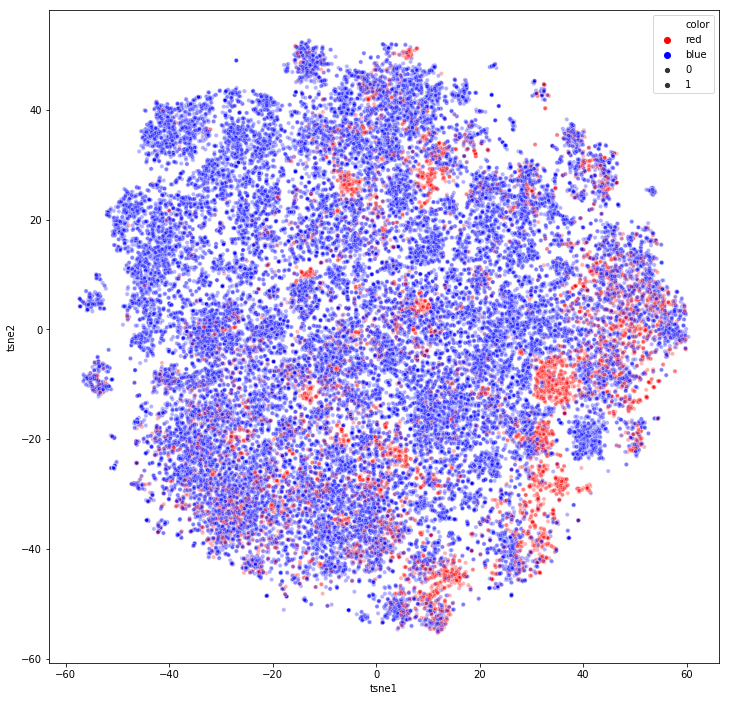

In [14]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=title_tsne, hue = 'color', hue_order=['red','blue'], palette=['red','blue'], ax=ax, alpha=0.3,size=1)

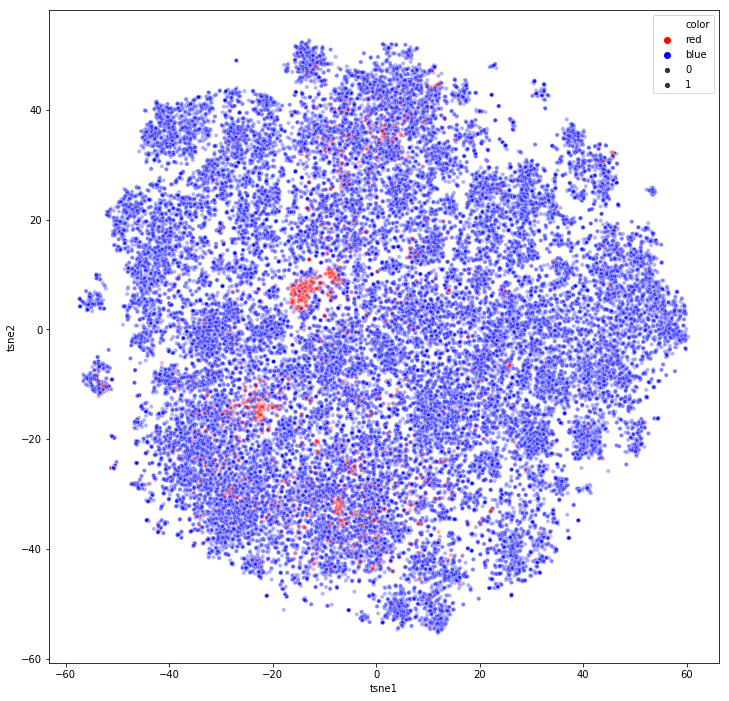

In [21]:
title_tsne['color']=title_tsne.pmid.apply(lambda x:'red' if x in egfr_pmid else 'blue')
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=title_tsne, hue = 'color', hue_order=['red','blue'], palette=['red','blue'], ax=ax, alpha=0.3,size=1)

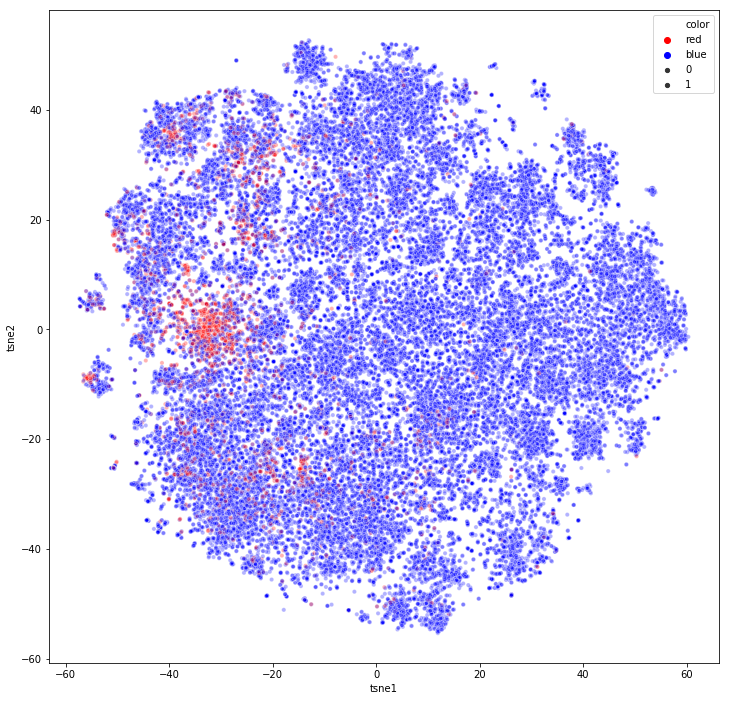

In [20]:
title_tsne['color']=title_tsne.pmid.apply(lambda x:'red' if x in ctla4_pmid else 'blue')
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=title_tsne, hue = 'color', hue_order=['red','blue'], palette=['red','blue'], ax=ax, alpha=0.3,size=1)

In [23]:
title_embed_breast = title_embed.loc[np.array(breast_pmid)]
title_tsne_breast = title_tsne.loc[np.array(breast_pmid)]
abstract_df_breast = abstract_df.loc[np.array(breast_pmid)]

In [24]:
tsne = TSNE()
title_embed_breast_tsne = tsne.fit_transform(title_embed_breast)
title_embed_breast_tsne=pd.DataFrame({'tsne1':title_embed_breast_tsne[:,0],'tsne2':title_embed_breast_tsne[:,1], 'pmid':title_embed_breast.index})

In [25]:
pmid_1 = doctor2pmid_dict['Kenneth Offit']
#pmid_1 = doctor2pmid_dict['Banu Arun']
#pmid_1 = doctor2pmid_dict['Claudine Isaacs']
#pmid_1 = doctor2pmid_dict['Monica Morrow']
#pmid_1 = doctor2pmid_dict['Kelly Hunt']
#pmid_1 = doctor2pmid_dict['Elizabeth A. Mittendorf']

In [27]:
title_embed_breast_tsne['color'] = title_embed_breast_tsne.pmid.apply(lambda x:'red' if str(x) in pmid_1 else 'blue')

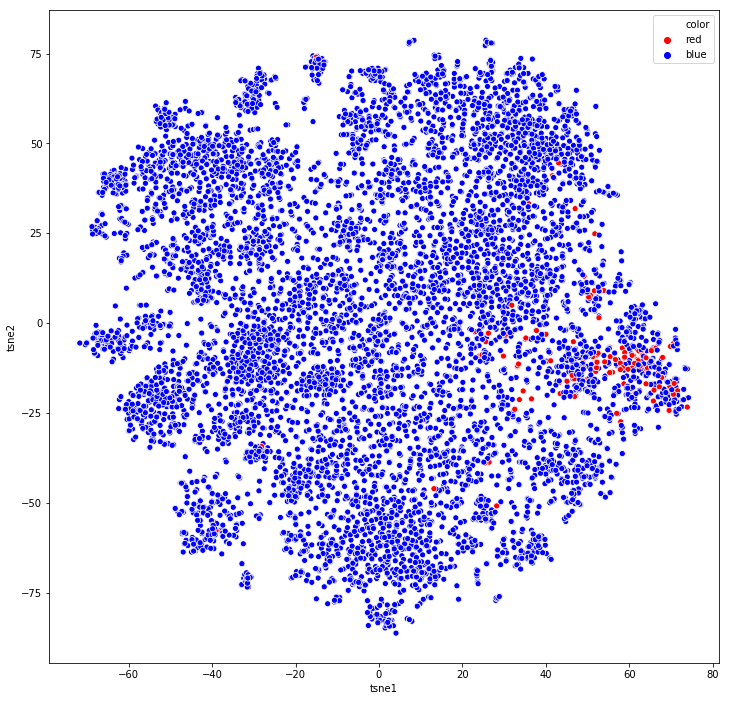

In [28]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=title_embed_breast_tsne, hue = 'color', hue_order=['red','blue'], palette=['red','blue'], ax=ax)

In [413]:
metastasis_list = abstract_df[abstract_df.metastasis==True].pmid.values
print(len(metastasis_list))

11261


In [414]:
metastasis_list

array([10581602, 11730853, 11750879, ..., 31892588, 31908224,  8678767])

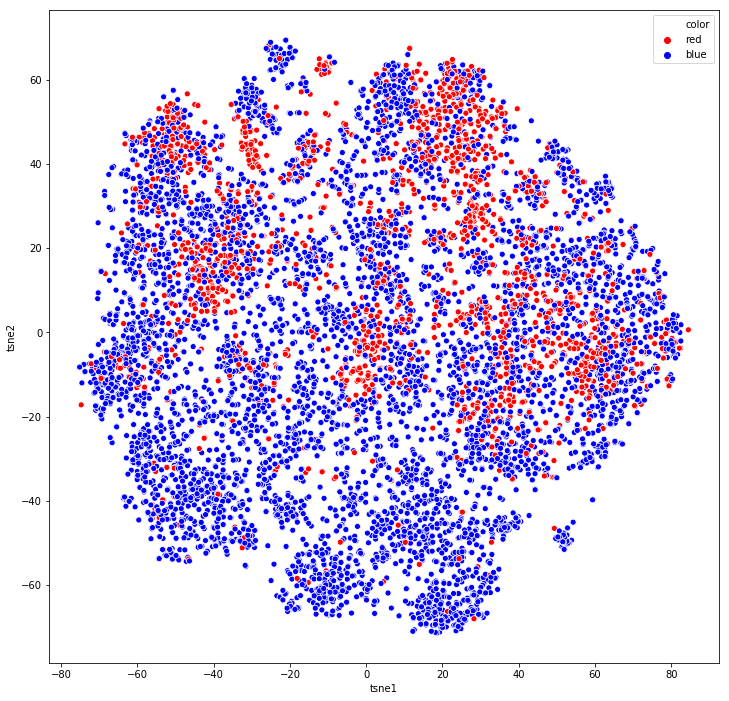

In [416]:
abstract_embed_breast_tsne['color'] = abstract_embed_breast_tsne.pmid.apply(lambda x:'red' if x in metastasis_list else 'blue')
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=abstract_embed_breast_tsne, hue = 'color', hue_order=['red','blue'], palette=['red','blue'], ax=ax)

In [18]:
brca_pmid = HGNC_flattened_df[HGNC_flattened_df.HGNC=='BRCA1/2'].pmid.values
ctla4_pmid = HGNC_flattened_df[HGNC_flattened_df.HGNC=='CTLA4'].pmid.values
erbb2_pmid = HGNC_flattened_df[HGNC_flattened_df.HGNC=='ERBB2'].pmid.values

In [508]:
len(erbb2_pmid)

306

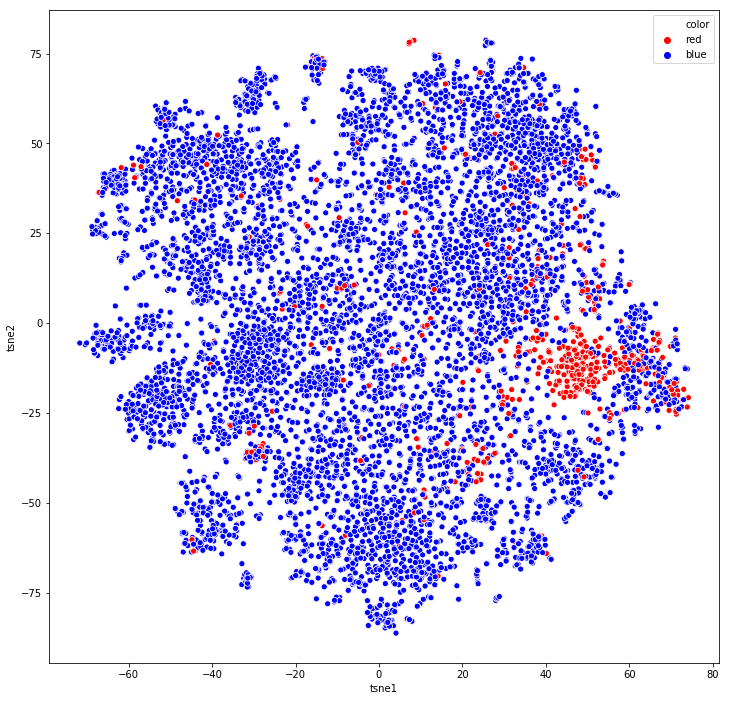

In [29]:
title_embed_breast_tsne['color'] = title_embed_breast_tsne.pmid.apply(lambda x:'red' if x in brca_pmid else 'blue')
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=title_embed_breast_tsne, hue = 'color', hue_order=['red','blue'], palette=['red','blue'], ax=ax)

In [426]:
tn_list=set(['triple', 'negative'])
title_df['tn']=title_df.unique_words.apply(lambda x:True if len(tn_list.intersection(set(x)))>=2 else False)
tn_list = title_df[title_df.tn==True].pmid.values
print(len(tn_list))

594


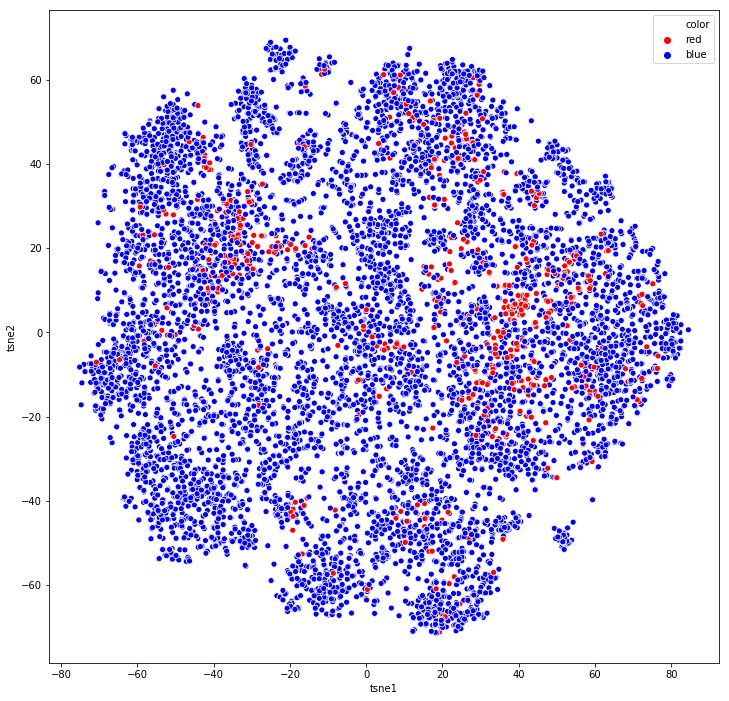

In [427]:
abstract_embed_breast_tsne['color'] = abstract_embed_breast_tsne.pmid.apply(lambda x:'red' if x in tn_list else 'blue')
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=abstract_embed_breast_tsne, hue = 'color', hue_order=['red','blue'], palette=['red','blue'], ax=ax)

In [30]:
melanoma_pmid = cancer2pmid_dict['Melanoma']

In [32]:
title_embed_melanoma = title_embed.loc[np.array(melanoma_pmid)]
title_tsne_melanoma = title_tsne.loc[np.array(melanoma_pmid)]
abstract_df_melanoma = abstract_df.loc[np.array(melanoma_pmid)]

In [33]:
tsne = TSNE()
title_embed_melanoma_tsne = tsne.fit_transform(title_embed_melanoma)
title_embed_melanoma_tsne=pd.DataFrame({'tsne1':title_embed_melanoma_tsne[:,0],'tsne2':title_embed_melanoma_tsne[:,1], 'pmid':title_embed_melanoma.index})

In [34]:
pmid_1 = doctor2pmid_dict['Jedd D. Wolchok']
#pmid_1 = doctor2pmid_dict['Elizabeth A. Mittendorf']

In [36]:
title_embed_melanoma_tsne['color'] = title_embed_melanoma_tsne.pmid.apply(lambda x:'red' if str(x) in pmid_1 else 'blue')

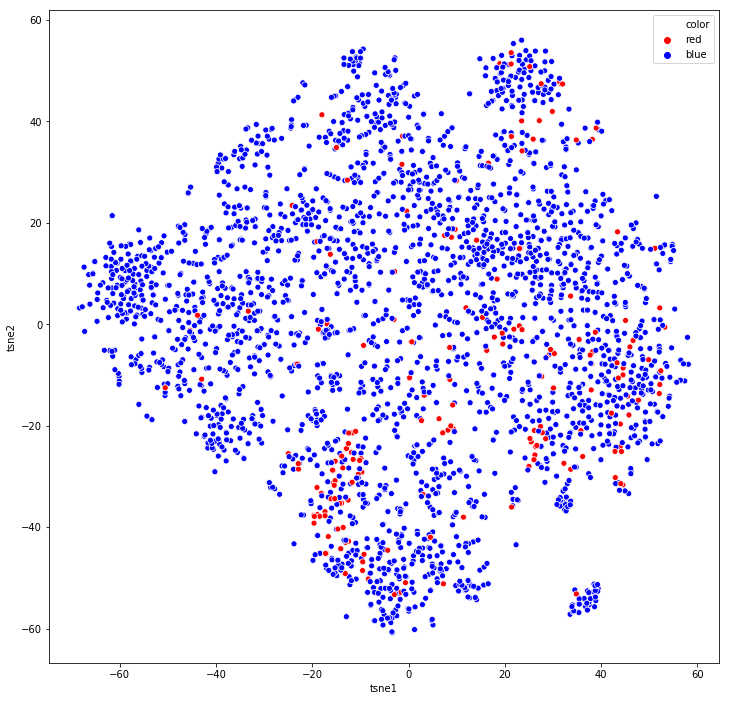

In [37]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=title_embed_melanoma_tsne, hue = 'color', hue_order=['red','blue'], palette=['red','blue'], ax=ax)

In [38]:
title_embed_melanoma_tsne['color'] = title_embed_melanoma_tsne.pmid.apply(lambda x:'red' if x in ctla4_pmid else 'blue')

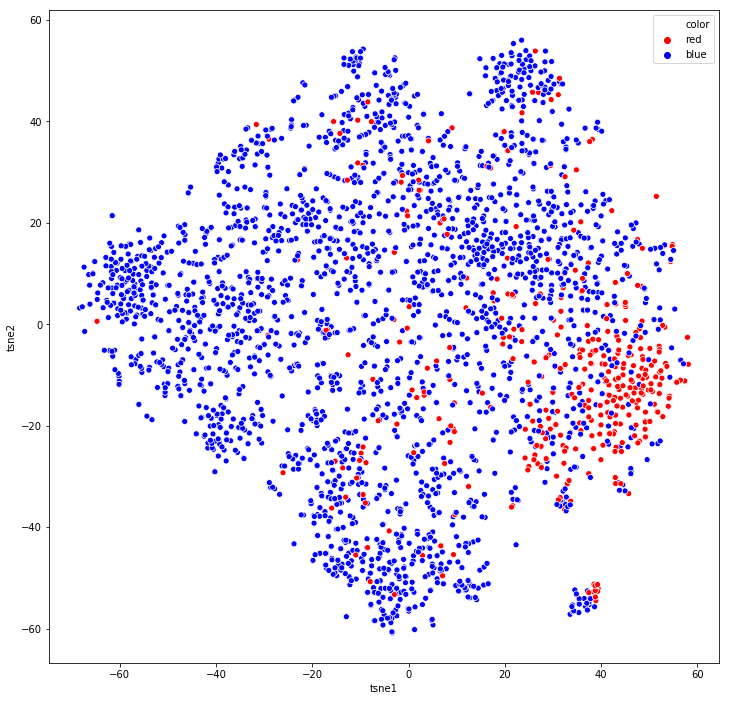

In [39]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=title_embed_melanoma_tsne, hue = 'color', hue_order=['red','blue'], palette=['red','blue'], ax=ax)

In [41]:
lung_pmid = cancer2pmid_dict['Lung Cancer']

title_embed_lung = title_embed.loc[np.array(lung_pmid)]
title_tsne_lung = title_tsne.loc[np.array(lung_pmid)]
abstract_df_lung = abstract_df.loc[np.array(lung_pmid)]

tsne = TSNE()
title_embed_lung_tsne = tsne.fit_transform(title_embed_lung)
title_embed_lung_tsne=pd.DataFrame({'tsne1':title_embed_lung_tsne[:,0],'tsne2':title_embed_lung_tsne[:,1], 'pmid':title_embed_lung.index})

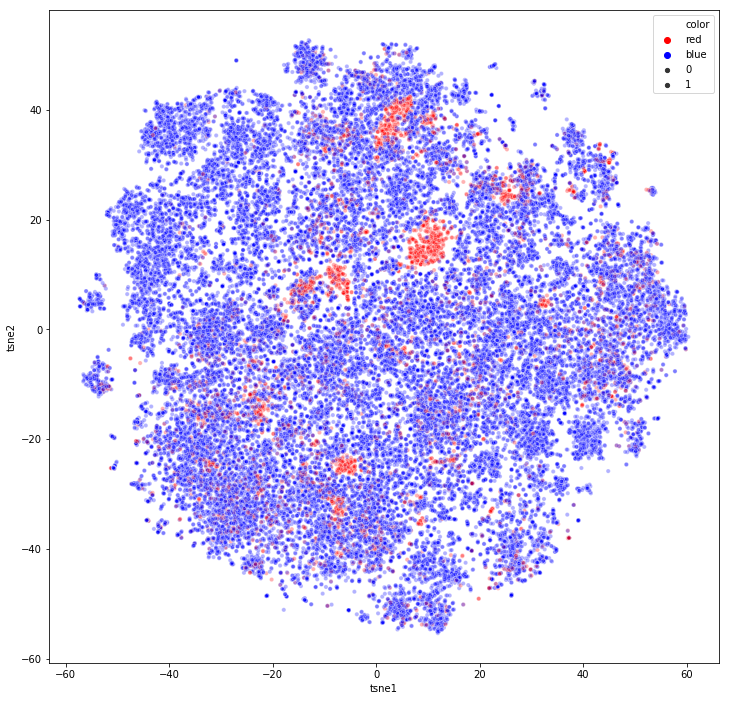

In [42]:
title_tsne['color']=title_tsne.pmid.apply(lambda x:'red' if x in lung_pmid else 'blue')
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=title_tsne, hue = 'color', hue_order=['red','blue'], palette=['red','blue'], ax=ax, alpha=0.3,size=1)

In [43]:
pmid_1 = doctor2pmid_dict['Charles M. Rudin']
#pmid_1 = doctor2pmid_dict['Elizabeth A. Mittendorf']

In [391]:
len(pmid_1)

162

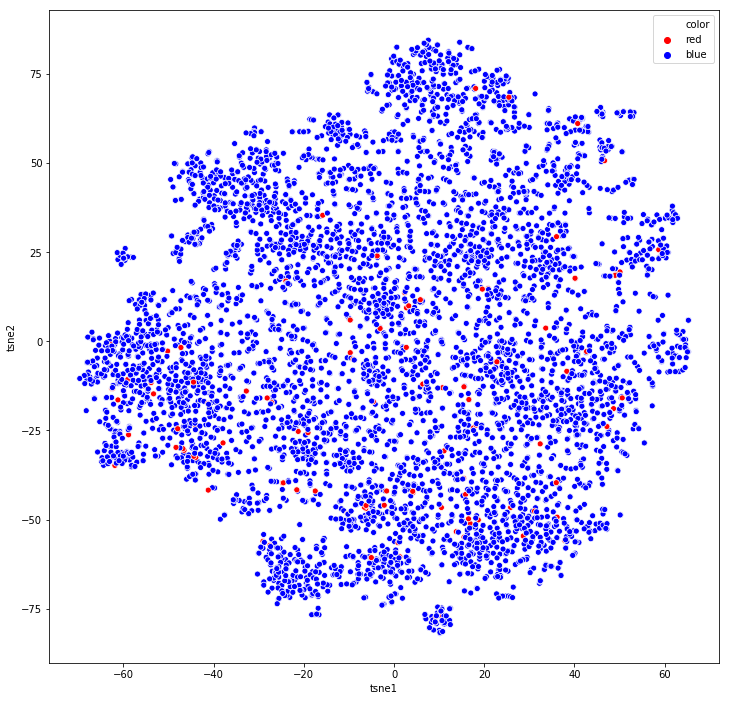

In [45]:
title_embed_lung_tsne['color'] = title_embed_lung_tsne.pmid.apply(lambda x:'red' if str(x) in pmid_1 else 'blue')
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=title_embed_lung_tsne, hue = 'color', hue_order=['red','blue'], palette=['red','blue'], ax=ax)

In [441]:
alk_pmid = HGNC_flattened_df[HGNC_flattened_df.HGNC=='ALK'].pmid.values
len(alk_pmid)

350

In [445]:
braf_pmid = HGNC_flattened_df[HGNC_flattened_df.HGNC=='BRAF'].pmid.values
len(braf_pmid)

920

In [46]:
egfr_pmid = HGNC_flattened_df[HGNC_flattened_df.HGNC=='EGFR'].pmid.values
kras_pmid = HGNC_flattened_df[HGNC_flattened_df.HGNC=='KRAS'].pmid.values
alk_pmid = HGNC_flattened_df[HGNC_flattened_df.HGNC=='ALK'].pmid.values
braf_pmid = HGNC_flattened_df[HGNC_flattened_df.HGNC=='BRAF'].pmid.values
egfr_pmid1 = np.setdiff1d(egfr_pmid, kras_pmid)
kras_pmid1 = np.setdiff1d(kras_pmid, egfr_pmid)
egfr_kras_pmid = np.intersect1d(egfr_pmid, kras_pmid)
print(len(egfr_pmid))
print(len(kras_pmid))
print(len(egfr_pmid1))
print(len(kras_pmid1))
print(len(egfr_kras_pmid))

1835
845
1557
567
278


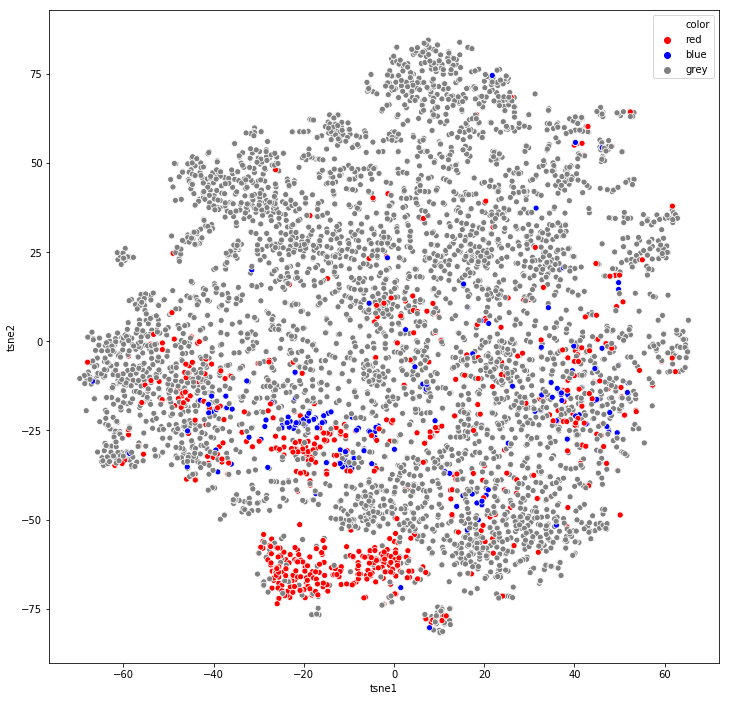

In [47]:
title_embed_lung_tsne['color'] = title_embed_lung_tsne.pmid.apply(lambda x:'red' if x in egfr_pmid1 else ('blue' if x in alk_pmid else 'grey'))
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=title_embed_lung_tsne, hue = 'color', hue_order=['red','blue','grey'], palette=['red','blue', 'grey'], ax=ax)

In [474]:
nsclc_pmid = abstract_df[abstract_df.NSCLC==True].pmid.values
sclc_pmid = abstract_df[abstract_df.SCLC==True].pmid.values

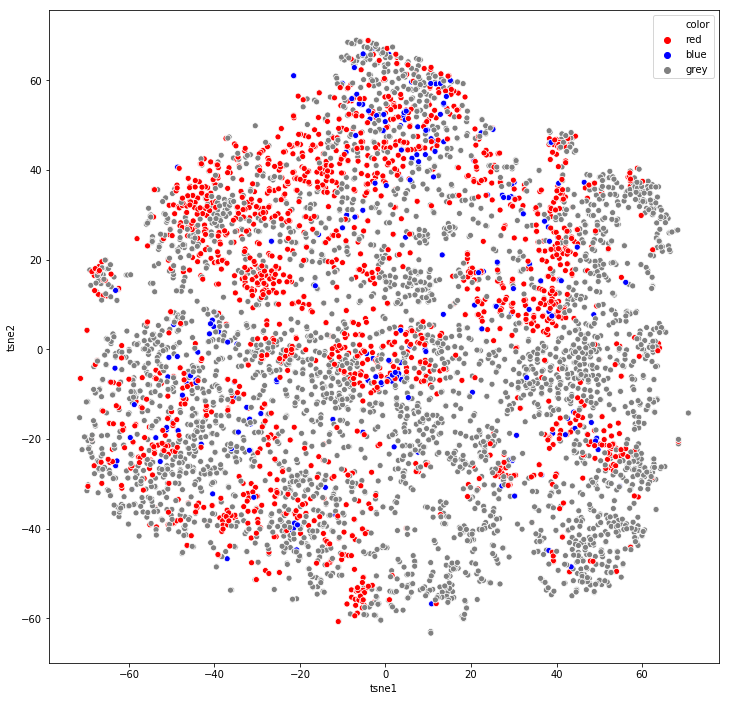

In [476]:
abstract_embed_lung_tsne['color'] = abstract_embed_lung_tsne.pmid.apply(lambda x:'red' if x in nsclc_pmid else ('blue' if x in sclc_pmid else 'grey'))
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=abstract_embed_lung_tsne, hue = 'color', hue_order=['red','blue','grey'], palette=['red','blue', 'grey'], ax=ax)

In [473]:
len(nsclc_pmid)

1732

In [475]:
len(sclc_pmid)

292

In [451]:
leukemia_pmid = cancer2pmid_dict['Leukemia']

abstract_embed_leukemia = abstract_embed.loc[np.array(leukemia_pmid)]
abstract_tsne_leukemia = abstract_tsne.loc[np.array(leukemia_pmid)]
abstract_df_leukemia = abstract_df.loc[np.array(leukemia_pmid)]

tsne = TSNE()
abstract_embed_leukemia_tsne = tsne.fit_transform(abstract_embed_leukemia)
abstract_embed_leukemia_tsne=pd.DataFrame({'tsne1':abstract_embed_leukemia_tsne[:,0],'tsne2':abstract_embed_leukemia_tsne[:,1], 'pmid':abstract_embed_leukemia.index})

In [462]:
all_pmid = cancer2pmid_dict['Acute Lymphoblastic Leukemia (ALL)']
cll_pmid = cancer2pmid_dict['Chronic Lymphocytic Leukemia (CLL)']
cml_pmid = cancer2pmid_dict['Chronic Myelogenous Leukemia (CML)']

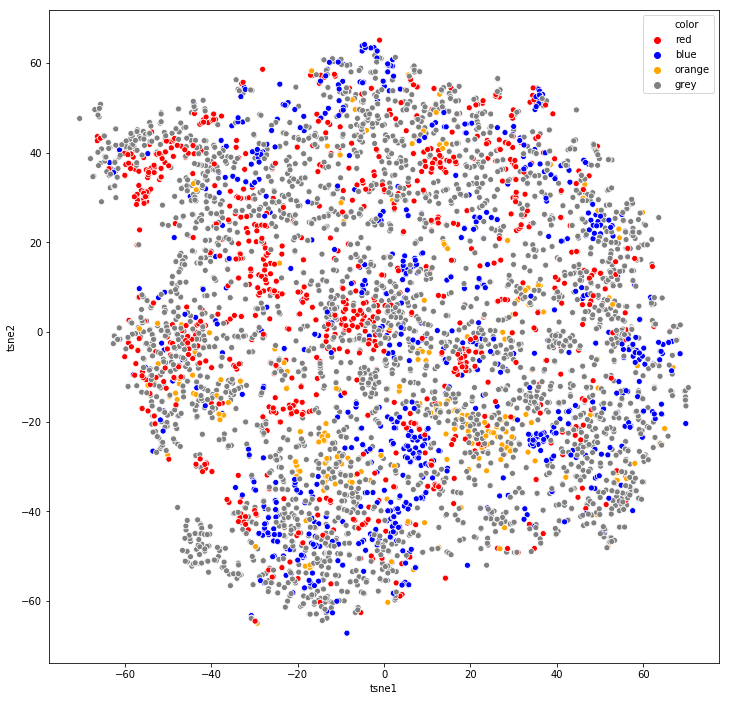

In [464]:
bcr_pmid = HGNC_flattened_df[HGNC_flattened_df.HGNC=='BCR'].pmid.values
abstract_embed_leukemia_tsne['color'] = abstract_embed_leukemia_tsne.pmid.apply(lambda x:'red' if x in all_pmid else ('blue' if x in cll_pmid else ('orange' if x in cml_pmid else 'grey')))
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=abstract_embed_leukemia_tsne, hue = 'color', hue_order=['red','blue', 'orange', 'grey'], palette=['red','blue', 'orange', 'grey'], ax=ax)

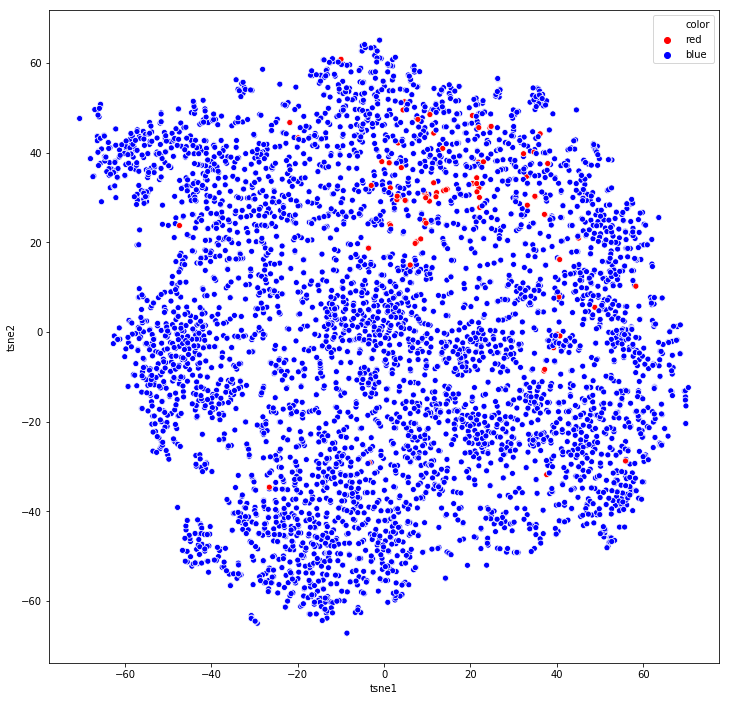

In [468]:
npm1_pmid = HGNC_flattened_df[HGNC_flattened_df.HGNC=='NPM1'].pmid.values
abstract_embed_leukemia_tsne['color'] = abstract_embed_leukemia_tsne.pmid.apply(lambda x:'red' if x in npm1_pmid else 'blue')
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=abstract_embed_leukemia_tsne, hue = 'color', hue_order=['red','blue'], palette=['red','blue'], ax=ax)

In [454]:
bcr_pmid = HGNC_flattened_df[HGNC_flattened_df.HGNC=='BCR'].pmid.values

In [467]:
HGNC_flattened_df.HGNC.unique()

array(['BCR', 'ABL1', 'DNMT1', 'AKT1', 'GLI1', 'CTLA4', 'SMARCA2', 'RB1',
       'ACTG1', 'APC', 'KMT2A', 'MET', 'SOS1', 'HGF', 'VEGFA', 'FLT1',
       'RTEL1', 'SDHB', 'MYC', 'EGFR', 'CALR', 'FH', 'BRCA1/2', 'SDHD',
       'HLA-C', 'ARID1A', 'DDIT3', 'FAT1', 'ERBB2', 'KIT', 'SRC', 'REL',
       'NTRK1', 'XIAP', 'AR', 'NKX2-1', 'ATM', 'MITF', 'YY1', 'INSR',
       'MSH2', 'PTEN', 'FANCC', 'CBL', 'RUNX1T1', 'CASP8', 'RIT1', 'ESR1',
       'REST', 'PGR', 'IGF1', 'VHL', 'NR4A3', 'FANCA', 'CYP19A1', 'RARA',
       'BLM', 'MAX', 'ETV6', 'MYCN', 'RET', 'EPCAM', 'ERCC4', 'U2AF1',
       'PPARG', 'GATA3', 'EIF4E', 'RASA1', 'LYN', 'CDKN2A', 'KDR',
       'AXIN1', 'IGF1R', 'SDHA', 'FOXP1', 'PDGFB', 'NPM1', 'NFKBIA',
       'CREB1', 'SDHC', 'ALK', 'BRD4', 'MST1', 'NT5C2', 'MTOR', 'MST1R',
       'CD79A', 'IRF8', 'PAX5', 'BRAF', 'MAP3K1', 'PDGFRA', 'CTCF',
       'FANCD2', 'FOXO1', 'PRKAR1A', 'MTAP', 'RELN', 'MEN1', 'GNAS',
       'ERCC2', 'MSH3', 'ALB', 'DDX3X', 'STK11', 'ARID1B', 'POLE', 'ATR',


In [430]:
len(egfr_pmid)

1835

In [389]:
doctor2pmid_dict.keys()

dict_keys(['John H. Glick', 'David M. Mintzer', 'David J. Vaughn', 'Marcia S. Brose', 'Robert G. Maki', 'Lee P. Hartner', 'Vandana Gupta Abramson', 'Jeremy S. Abramson', 'Maureen R. Hewitt', 'Richard J. Gralla', 'Diogo Bugano Diniz Gomes', 'Claudia M. Dourado', 'Fernando Moura', 'Vladimir Galvão Aguiar', 'Oren Smaletz', 'Haiying Cheng', 'Heloisa Veasey Rodrigues', 'Joseph A. Sparano', 'Stuart H. Packer', 'Aditi Shastri', 'Fabio Pires De Souza Santos', 'Evan Hersh', 'Alan Langerak', 'Scott Tannehill', 'Abhimanyu Ghose', 'Steven E. Schild', 'Karen S. Anderson', 'Mike Janicek', 'Mitesh J. Borad', 'Daniel Oscar Persky', 'Cassandra N. Moore', 'Julie E. Bauman', 'Jue Wang', 'Chenthilmurugan Rathnasabapathy', 'Mazen Khattab', 'Rachna T. Shroff', 'William Wong', 'Brendan F. Curley', 'Joseph Buscema', 'Pavani Chalasani', 'Raymond Taetle', 'Setsuko K. Chambers', 'Baldassarre Stea', 'Helen J. Ross', 'Manuel R. Modiano', 'Wishwdeep S. Dhillon', 'Devinder Singh', 'Shaachi Gupta', 'Clarence Sarkodee

In [160]:
abstract_embed = embed_sents(abstract_df.abstract_clean.values.tolist(), model)
title_embed = embed_sents(abstract_df.title_clean.values.tolist(), model)

0


In [169]:
similarity_score = cosine_similarity(X=abstract_embed[:1,:],Y=title_embed[:1,:],dense_output=False)

In [165]:
abstract_embed.shape

(50930, 768)

### Rank similarity scores in each cancer_type

In [175]:
cancer_types=np.array(cancertype_flattened_df.cancer_type.value_counts().index)
cancer2pmid_dict=pickle.load(open(os.path.join(base_dir, "data/cancer2pmid_dict.pkl"),"rb"))

In [182]:
abstract_embedded_df = pd.read_csv(os.path.join(base_dir, 'bert_data/abstract_embed_bert_maxlen128.csv'),index_col='pmid')
title_embedded_df = pd.read_csv(os.path.join(base_dir, 'bert_data/title_embed_bert_maxlen128.csv'),index_col='pmid')

In [202]:
def bert_title_rank(pmid):
    title_query = title_embedded_df.loc[pmid].values.reshape(1,-1)
    similarity_score = cosine_similarity(X=subset_abstract_embedded_df,Y=title_query,dense_output=False)
    similarity_df=pd.DataFrame({'pmid':subset_abstract_embedded_df.index, 'bert_score':similarity_score.squeeze()}).sort_values(by=['bert_score'],ascending=False).reset_index().drop(['index'],axis=1)
    return int(similarity_df.index[similarity_df.pmid==pmid].values)

In [212]:
for cancer_type in cancer_types:
    prefix="_".join(i.lower() for i in cancer_type.split())
    pmid_list = cancer2pmid_dict[cancer_type]
    subset_df=abstract_df.loc[pmid_list]
    subset_abstract_embedded_df=abstract_embedded_df.loc[subset_df.index]
    subset_df['bert_similarity_rank_{}'.format(prefix)] = subset_df.apply(lambda x:bert_title_rank(x.pmid),axis=1)
    subset_df['bert_similarity_rank_{}_percentile'.format(prefix)] = subset_df['bert_similarity_rank_{}'.format(prefix)]/subset_df.shape[0]
    subset_df.to_csv(os.path.join(base_dir, 'bert_data/{}_bert_maxlen128_similarity_score.csv'.format(prefix)), index=False)

Breast Cancer
subset_df: (8563, 10)
Lung Cancer
subset_df: (5518, 10)
Leukemia
subset_df: (4962, 10)
Prostate Cancer
subset_df: (4018, 10)
Colorectal Cancer
subset_df: (3611, 10)
Lymphoma
subset_df: (3003, 10)
Bone Cancer
subset_df: (2859, 10)
Melanoma
subset_df: (2742, 10)
Liver Cancer
subset_df: (2584, 10)
Kidney Cancer
subset_df: (2315, 10)
Ovarian Cancer
subset_df: (2363, 10)
Pancreatic Cancer
subset_df: (2132, 10)
Brain Tumor
subset_df: (3103, 10)
Head and Neck Cancer
subset_df: (1996, 10)
Acute Myeloid Leukemia (AML)
subset_df: (1499, 10)
Multiple Myeloma
subset_df: (1425, 10)
Sarcoma
subset_df: (1477, 10)
Bladder Cancer
subset_df: (1151, 10)
Skin Cancer
subset_df: (1124, 10)
Gastric Cancer
subset_df: (1064, 10)
Gastrointestinal Tumor
subset_df: (989, 10)
Endometrial Cancer
subset_df: (1053, 10)
Acute Lymphoblastic Leukemia (ALL)
subset_df: (915, 10)
Chronic Lymphocytic Leukemia (CLL)
subset_df: (803, 10)
Cardiac Tumors
subset_df: (862, 10)
Cervical Cancer
subset_df: (884, 10)
Es

In [215]:
def plot_bert_similarity_rank(cancer_type):
    prefix="_".join(i.lower() for i in cancer_type.split())
    subset_df = pd.read_csv(os.path.join(base_dir, 'bert_data/{}_bert_maxlen128_similarity_score.csv'.format(prefix)))
    subset_df['bert_similarity_rank_{}_percentile'.format(prefix)] = subset_df['bert_similarity_rank_{}'.format(prefix)]/subset_df.shape[0]
    
    fig,ax=plt.subplots(1,1,figsize=(12,6))
    sns.distplot(subset_df['bert_similarity_rank_{}_percentile'.format(prefix)], hist=True,kde=False,bins=int(subset_df.shape[0]/50) if subset_df.shape[0]>1000 else 20,ax=ax,hist_kws={'edgecolor':'black'})
    ax.set_xlim(0,1)
    ax.set_xlabel('bert_similarity_score_rank_percentile_{}'.format(prefix), fontsize=12)
    ax.set_yticks([])
    ax.set_title('Distribution of bert similarity score rank for {}'.format(cancer_type), fontsize=18)
    plt.show()
    fig.savefig(os.path.join(base_dir, 'bert_data/{}_bert_maxlen128_similarity_score.png'.format(prefix)))

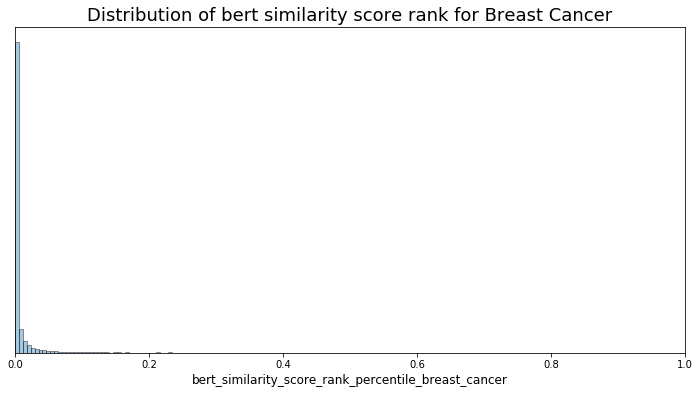

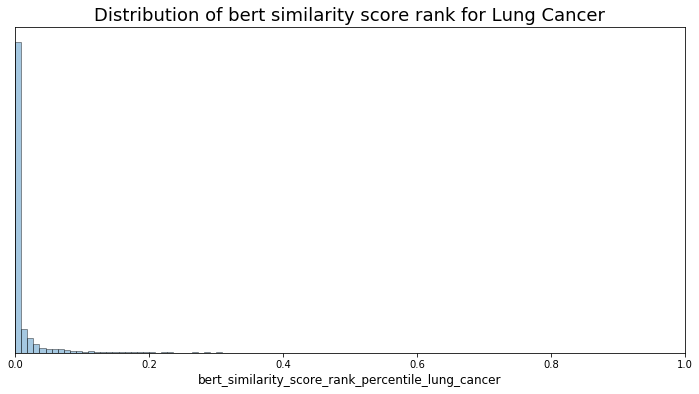

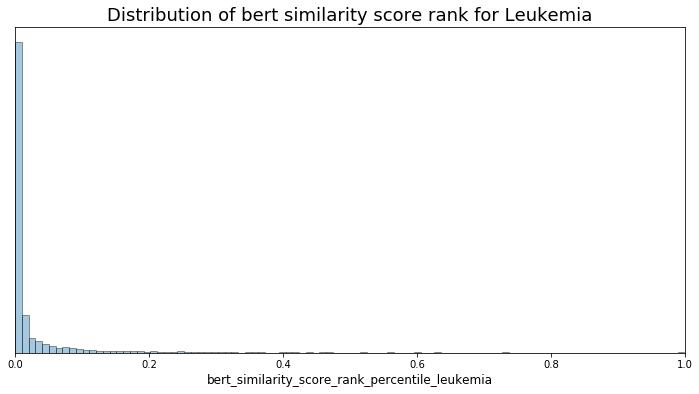

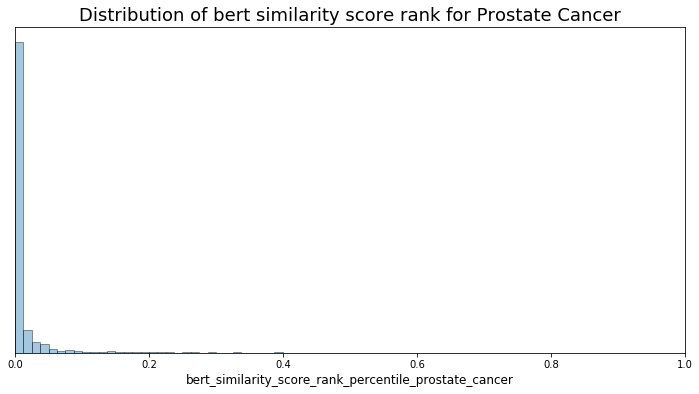

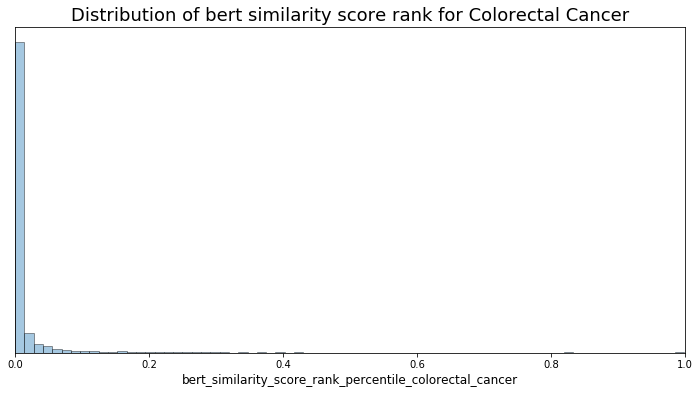

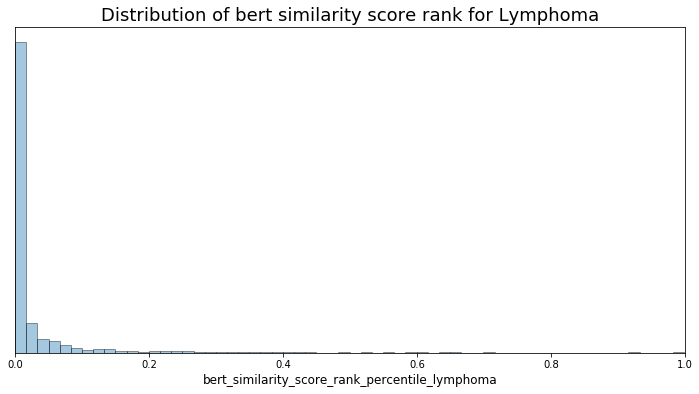

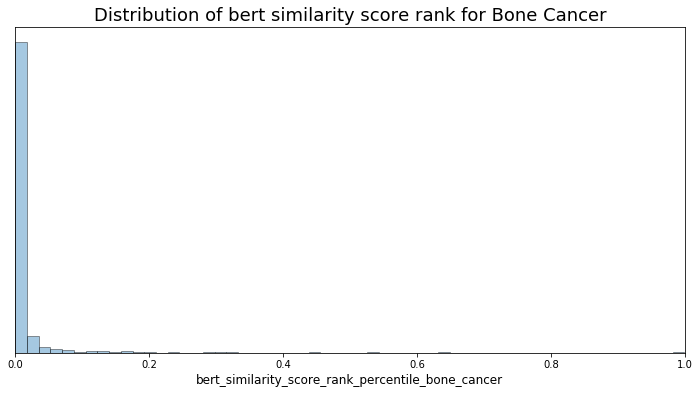

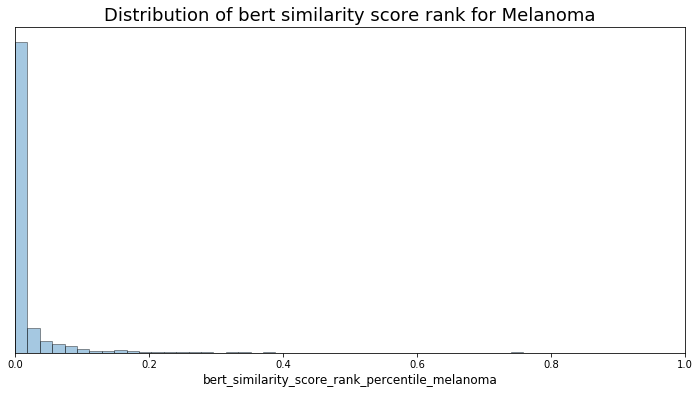

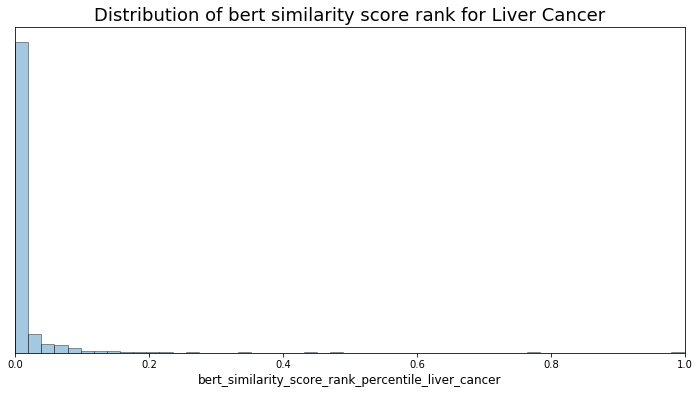

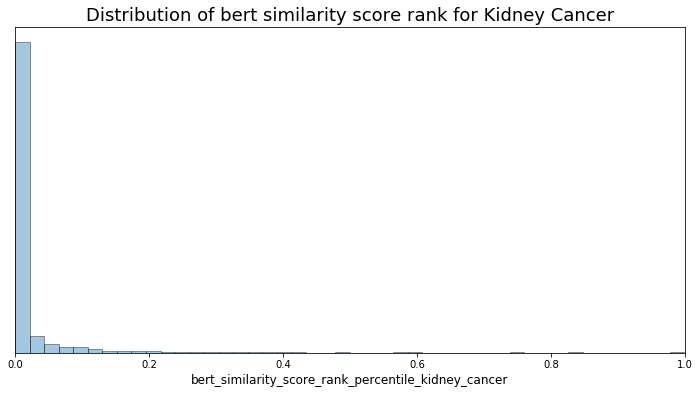

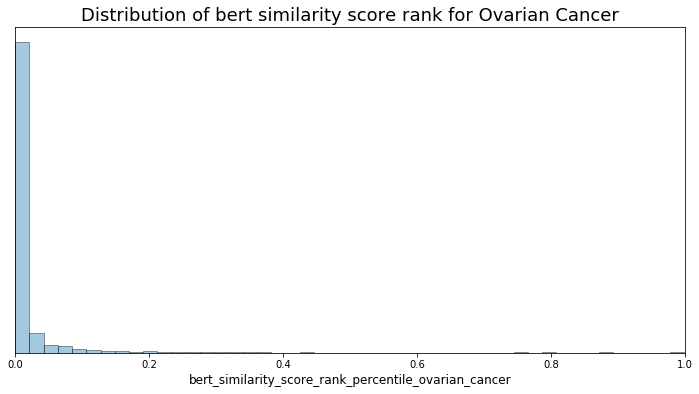

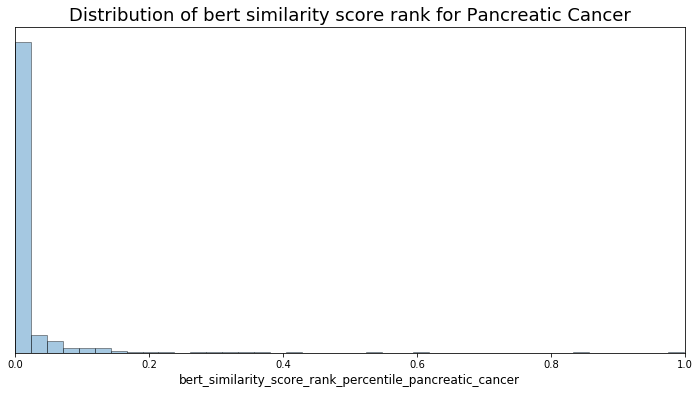

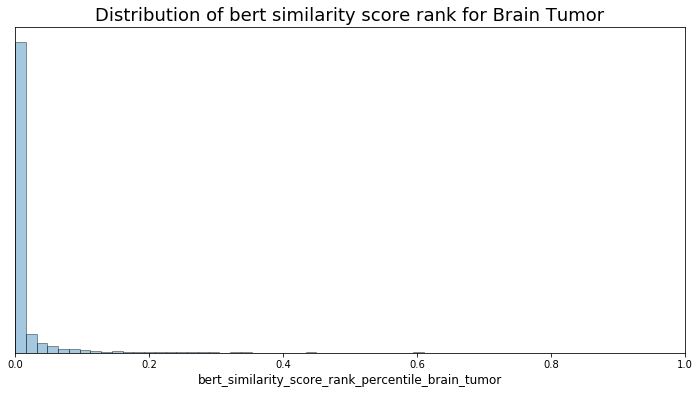

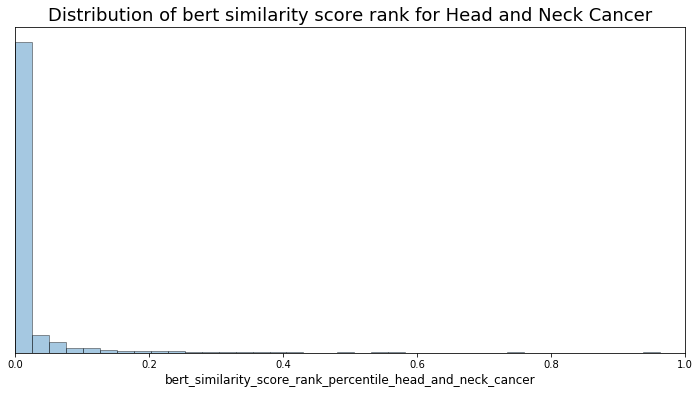

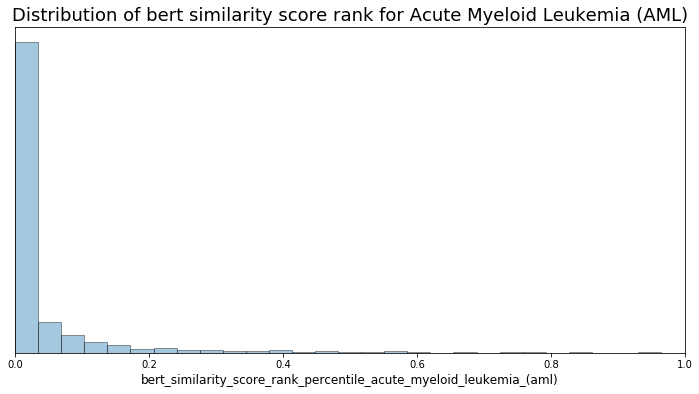

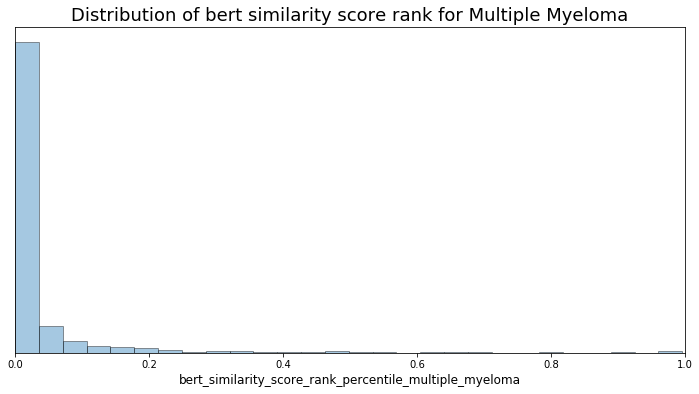

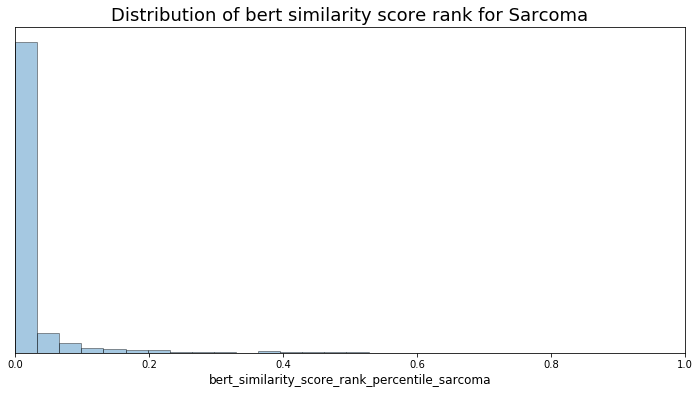

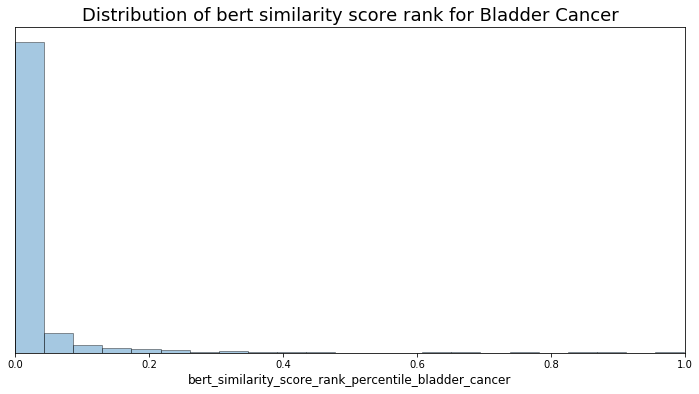

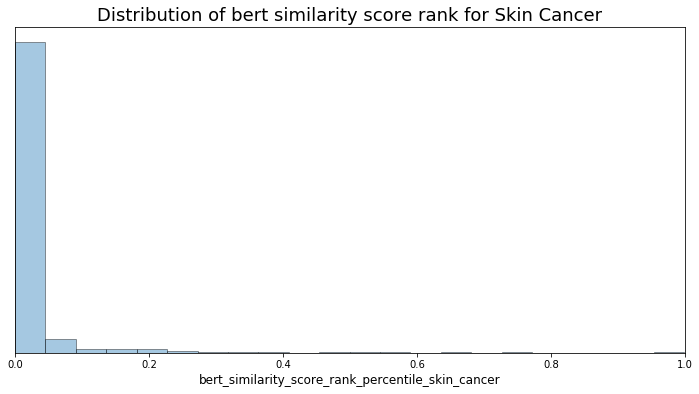

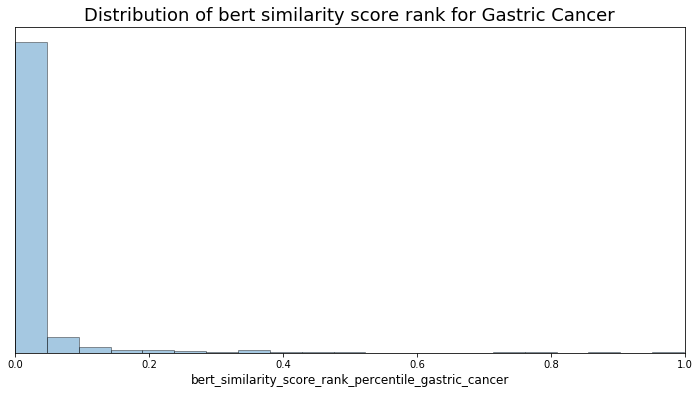

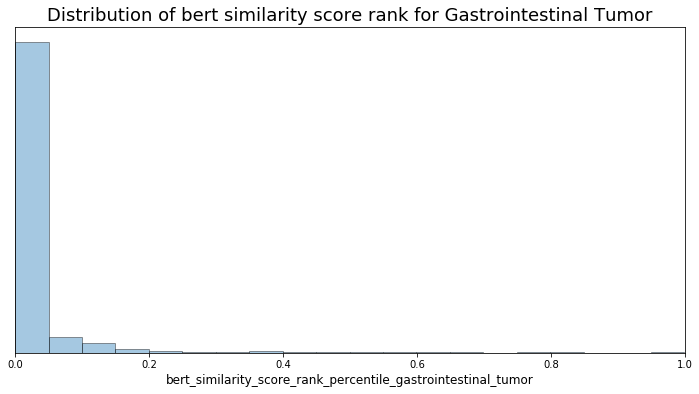

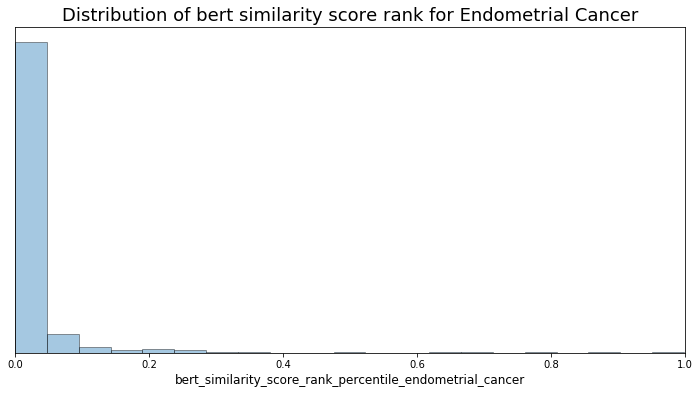

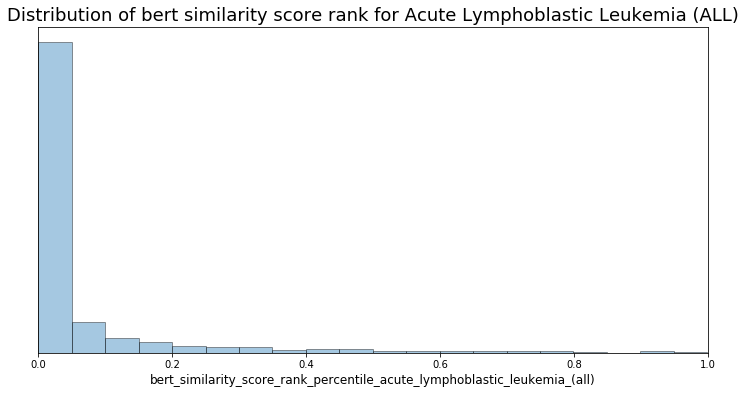

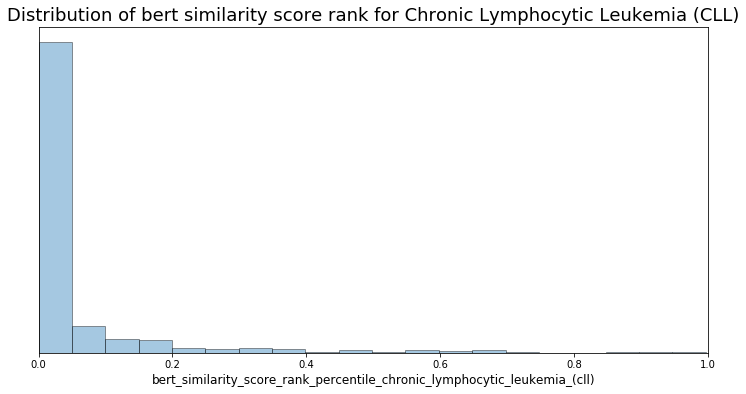

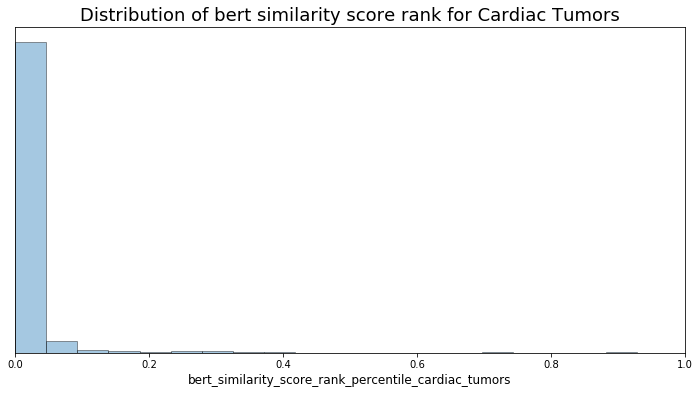

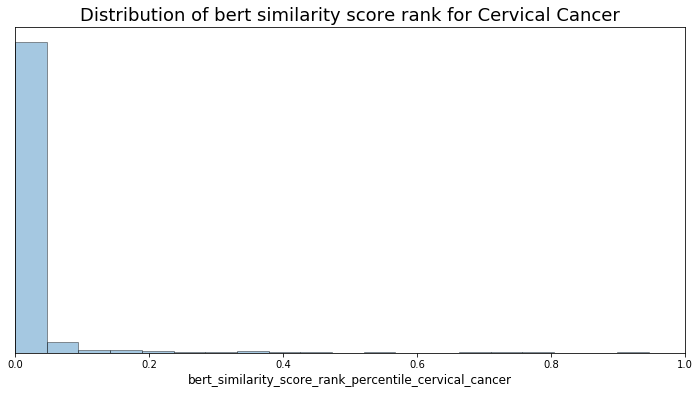

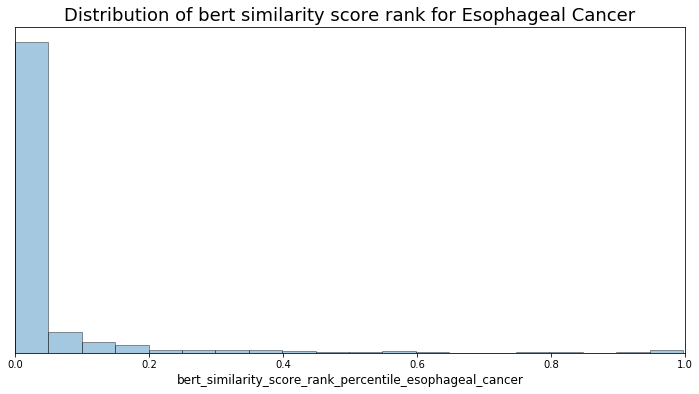

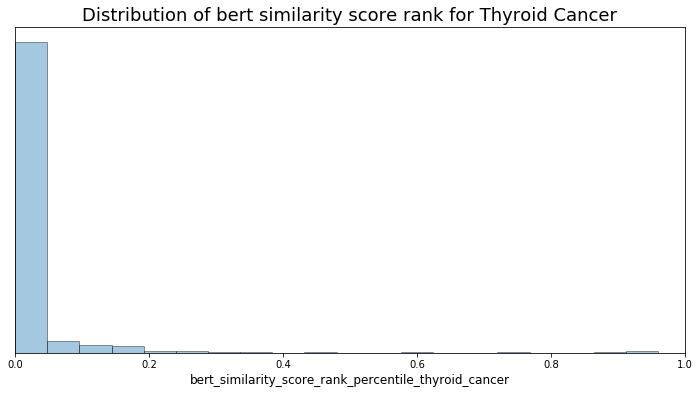

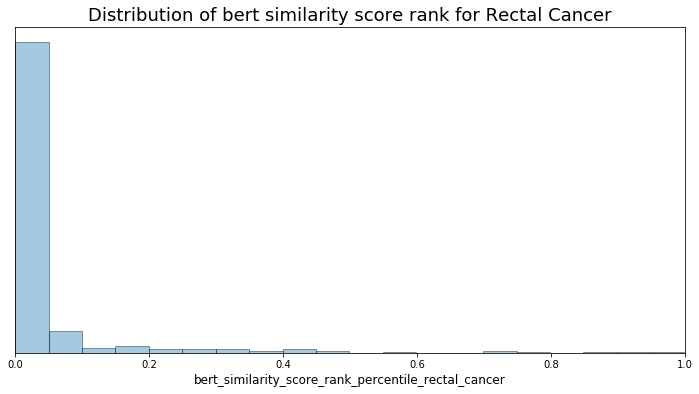

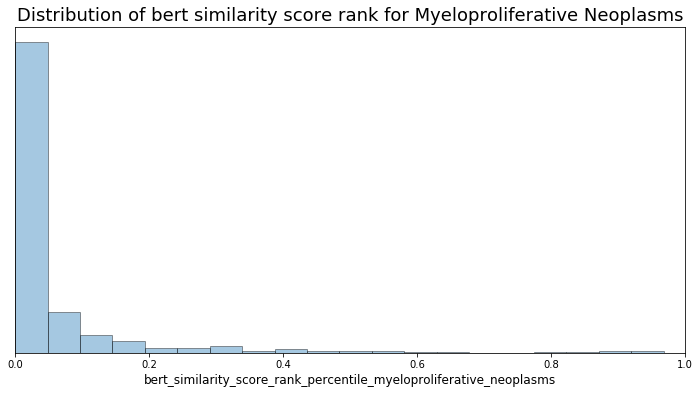

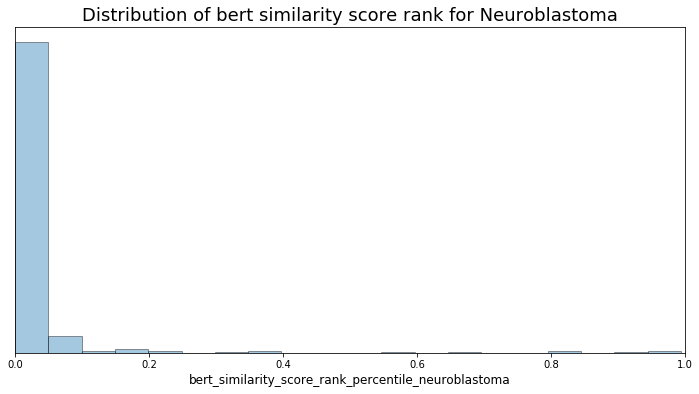

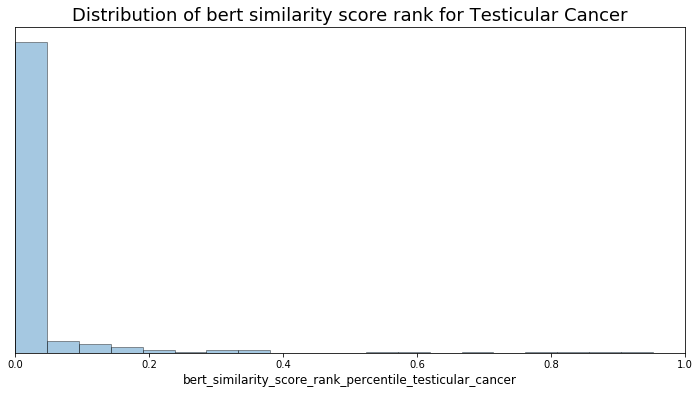

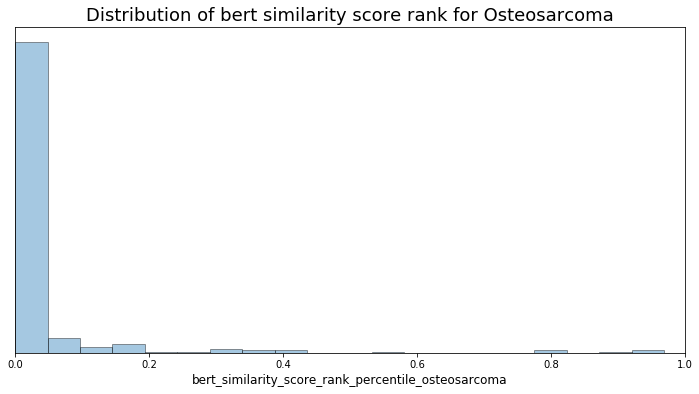

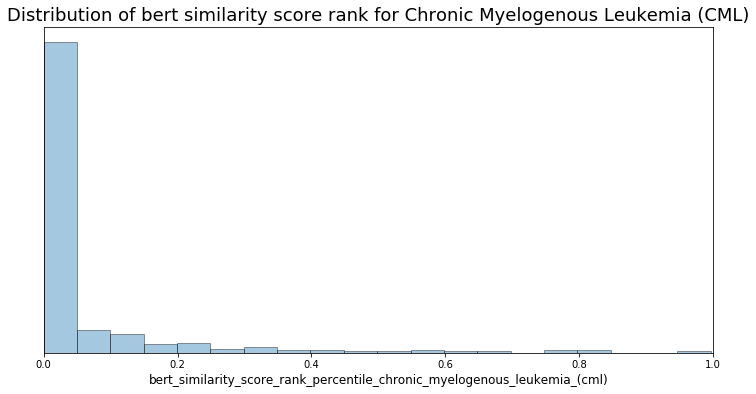

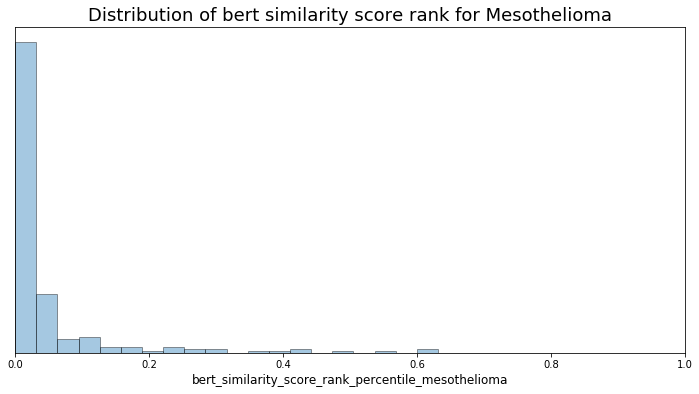

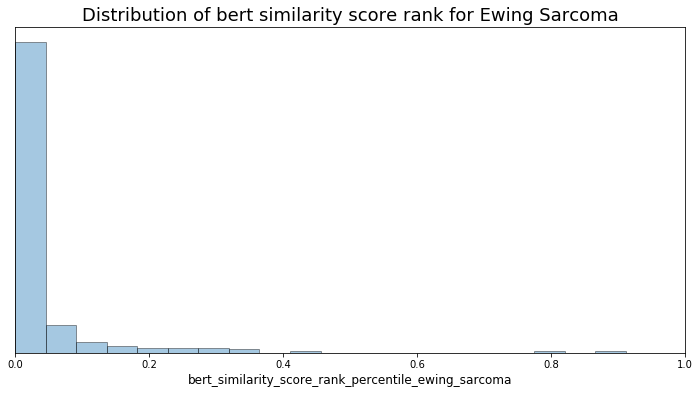

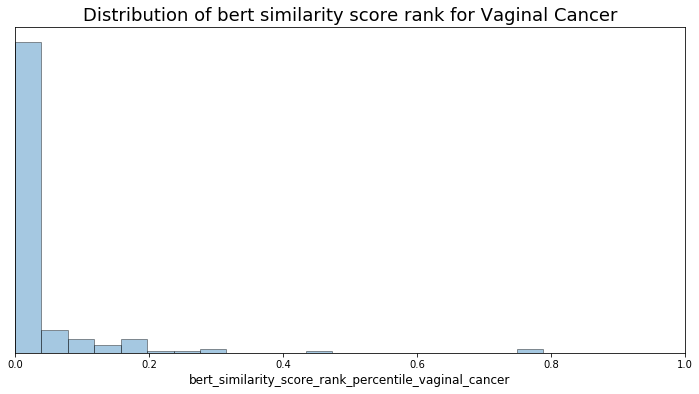

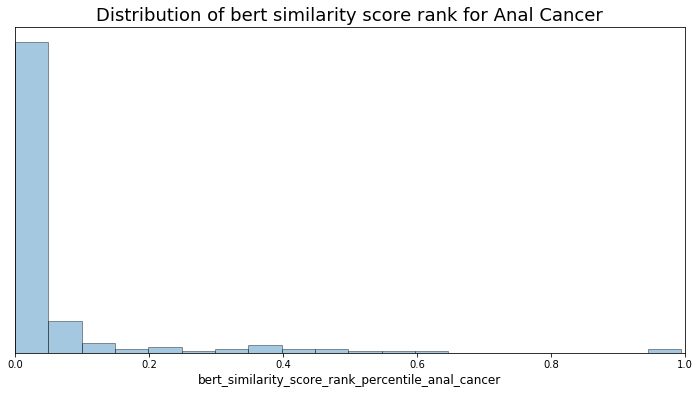

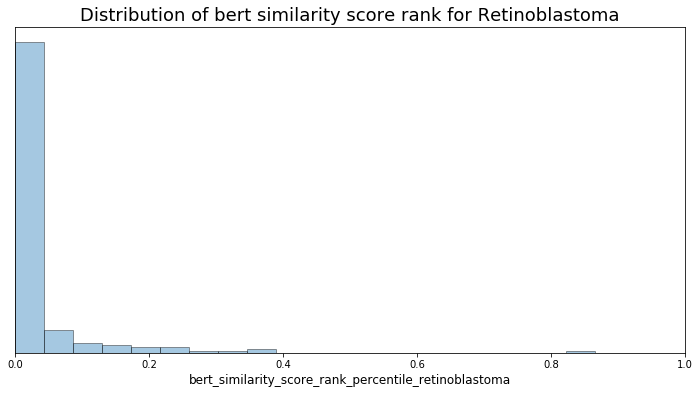

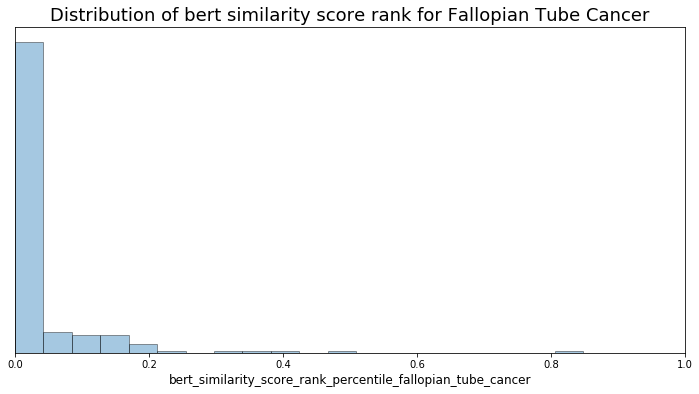

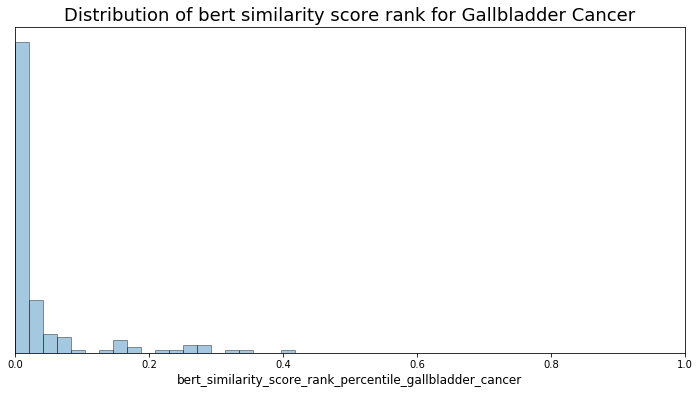

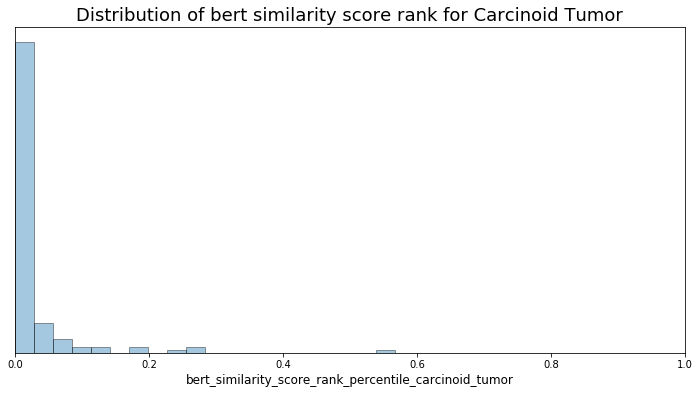

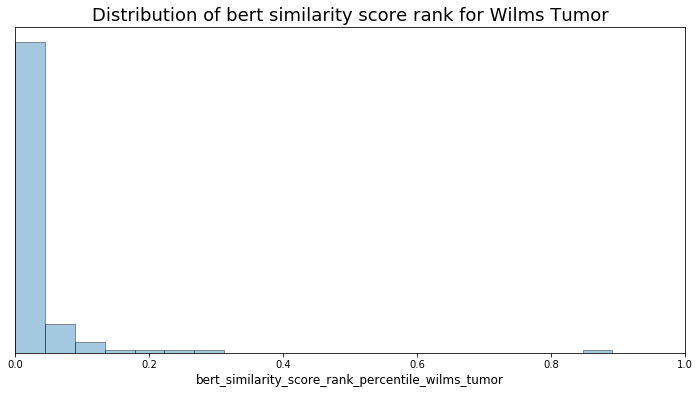

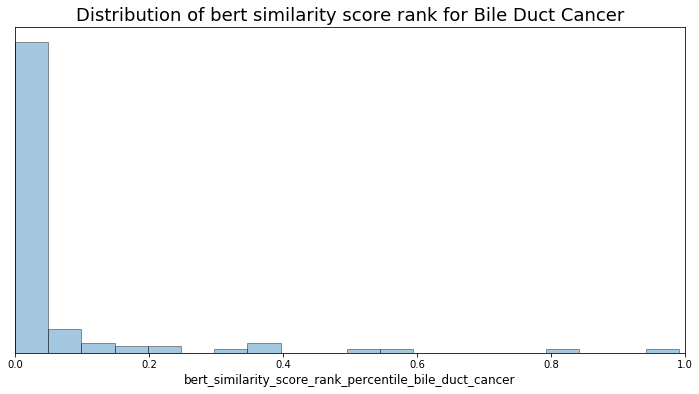

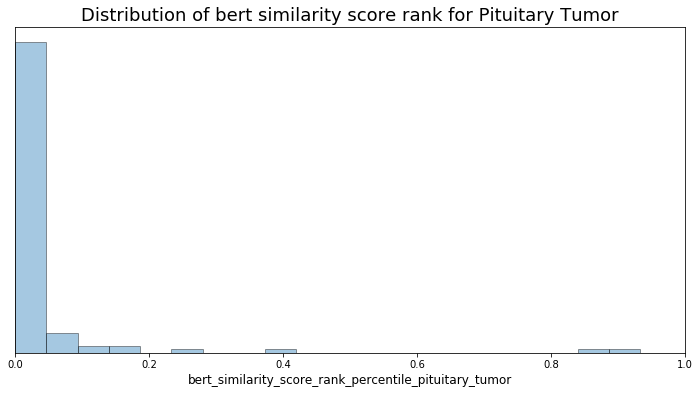

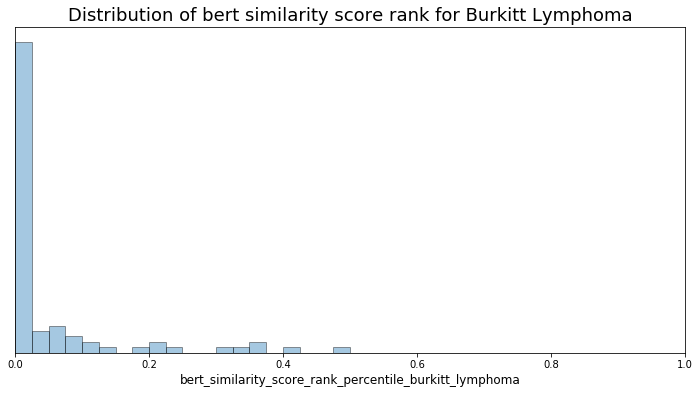

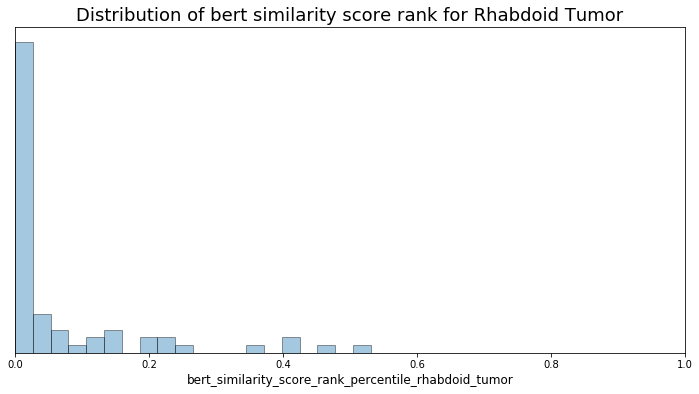

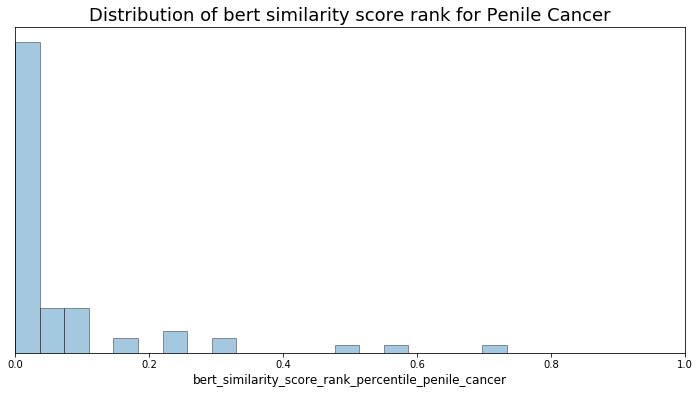

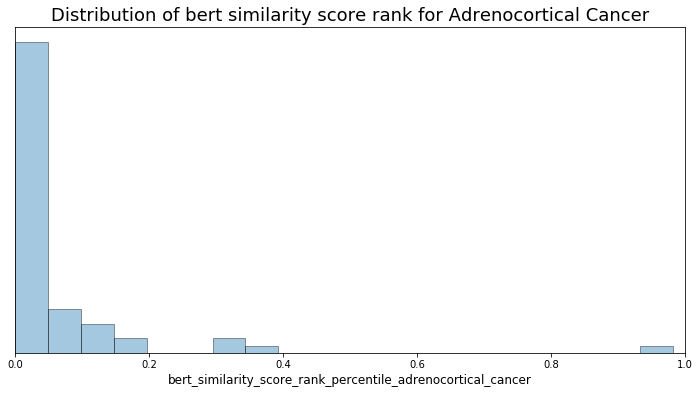

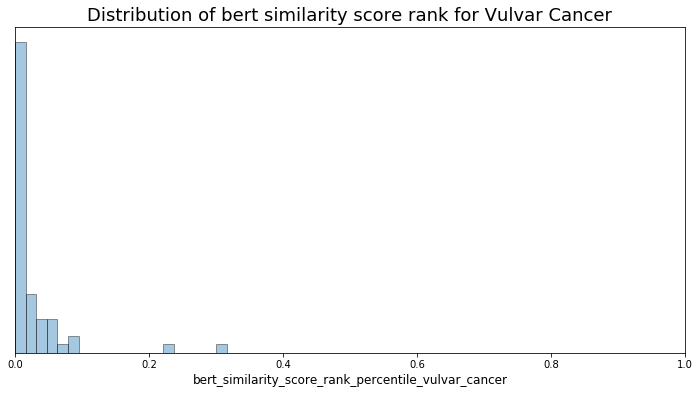

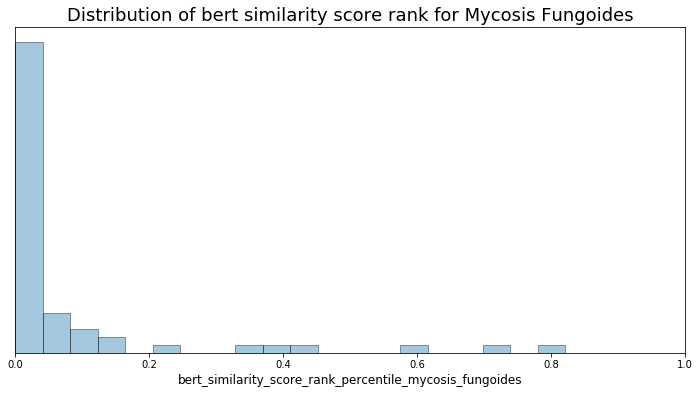

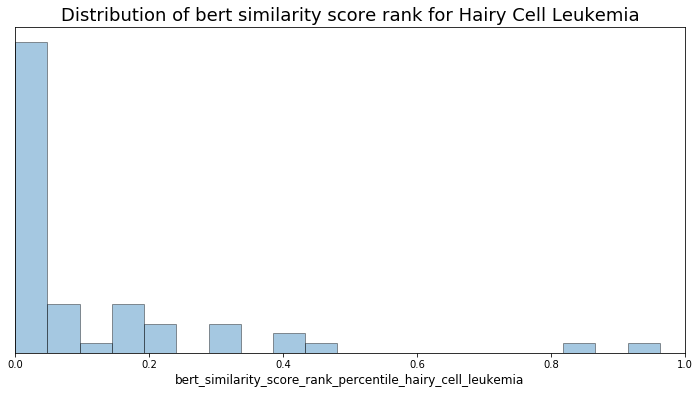

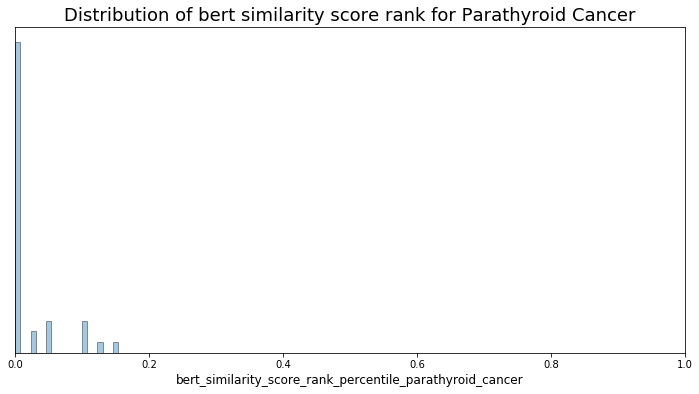

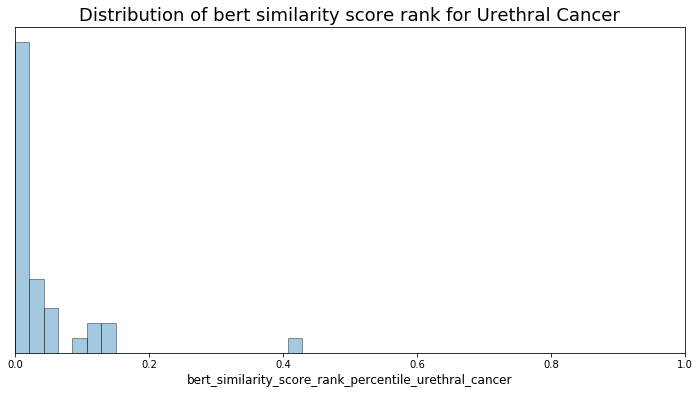

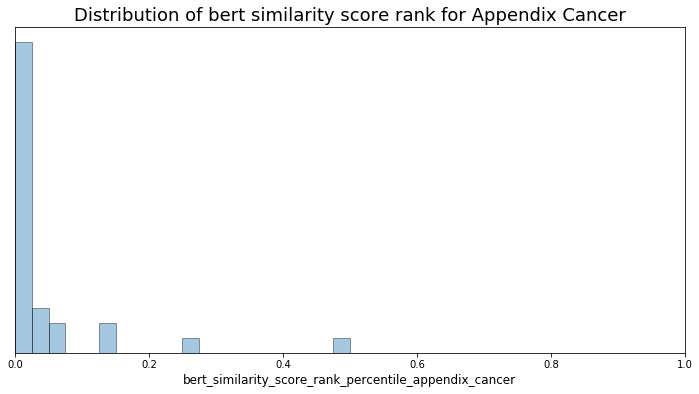

In [216]:
for cancer_type in cancer_types:
    plot_bert_similarity_rank(cancer_type)

In [205]:
title_query.shape

(8563, 768)

In [217]:
cancer_type='Breast Cancer'
prefix="_".join(i.lower() for i in cancer_type.split())
subset_df = pd.read_csv(os.path.join(base_dir, 'bert_data/{}_bert_maxlen128_similarity_score.csv'.format(prefix)))   

In [188]:
title_embedded_df.loc[2357786].values.reshape(-1,1)

(768, 1)

### Query sentence

In [232]:
original_text = 'The patient is looking for therapies for breast cancer'

In [236]:
emb_mat = embed_sents([original_text], model,max_len=128)